# Installing libraries and loading data

In [58]:
pip install umap-learn  numpy pandas seaborn matplotlib scikit-learn IPython scipy statsmodels --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Menashe Lorenzi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [59]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

# שתיקה על כל אזהרות מסוג זה
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import sklearn
import umap
import IPython
import scipy
import statsmodels

packages = {
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'seaborn': sns.__version__,
    'matplotlib': matplotlib.__version__,
    'scikit-learn': sklearn.__version__,
    'umap-learn': umap.__version__,
    'IPython': IPython.__version__,
    'scipy': scipy.__version__,
    'statsmodels': statsmodels.__version__,
}

for name, ver in packages.items():
    print(f"{name}: {ver}")


numpy: 2.2.5
pandas: 2.2.3
seaborn: 0.13.2
matplotlib: 3.10.1
scikit-learn: 1.6.1
umap-learn: 0.5.7
IPython: 9.2.0
scipy: 1.15.2
statsmodels: 0.14.4


In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, mutual_info_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE, Isomap
from sklearn.feature_selection import mutual_info_classif
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from IPython.display import display
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#0 - Creating a Dataset

In [62]:
sample_df = pd.read_csv("sample_data.csv")
print(sample_df.shape)
print(sample_df.head(3))

(20000, 32)
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        203               2016           December   
1    City Hotel            1         82               2015               July   
2    City Hotel            0         25               2016           December   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        49                          2   
1                        29                         16   
2                        53                         27   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        2                     5       2  ...    No Deposit   
1                        0                     3       2  ...    No Deposit   
2                        0                     3       3  ...    No Deposit   

   agent company days_in_waiting_list    customer_type   adr  \
0  250.0     NaN                    0        Tran

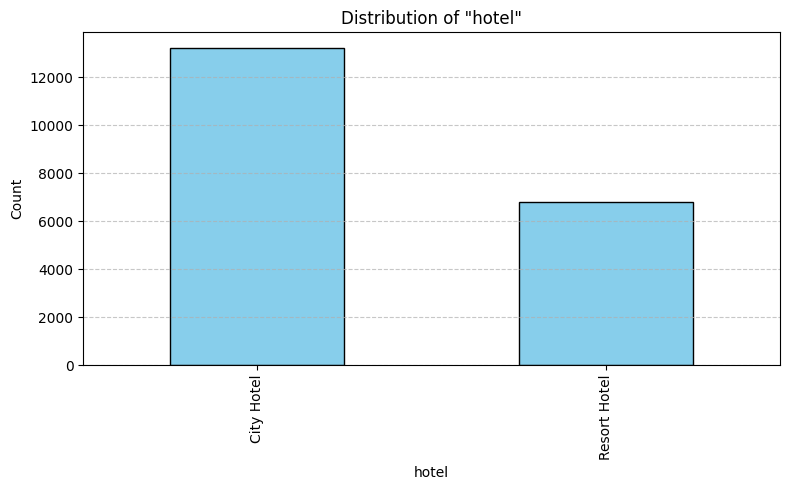

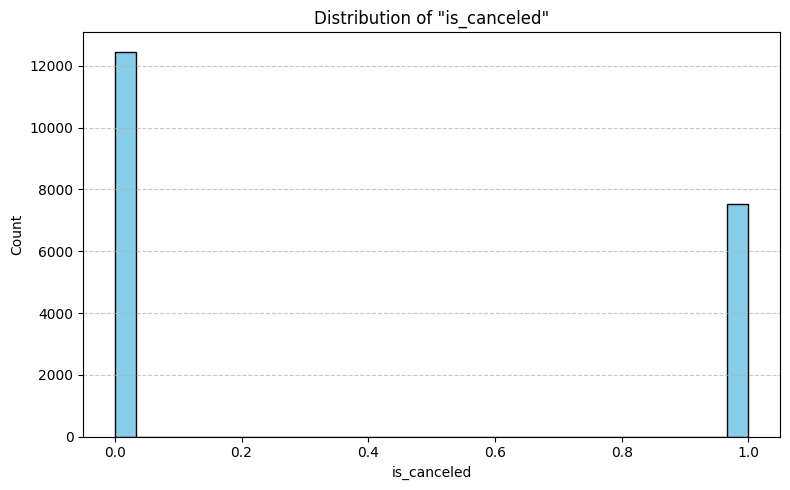

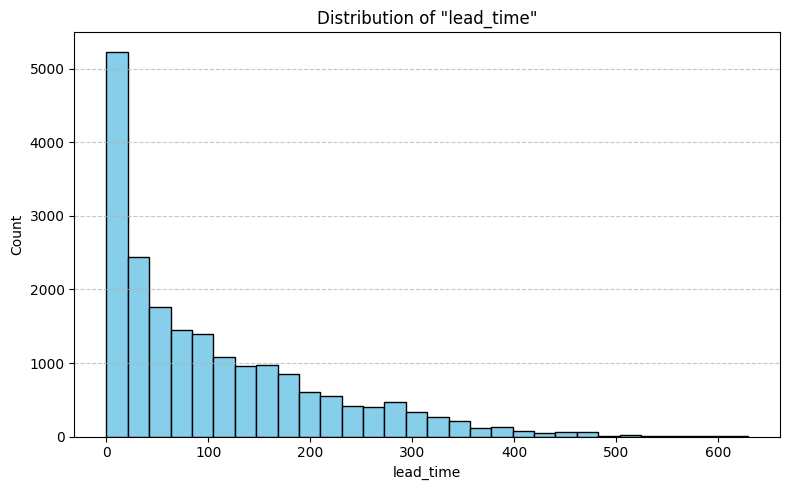

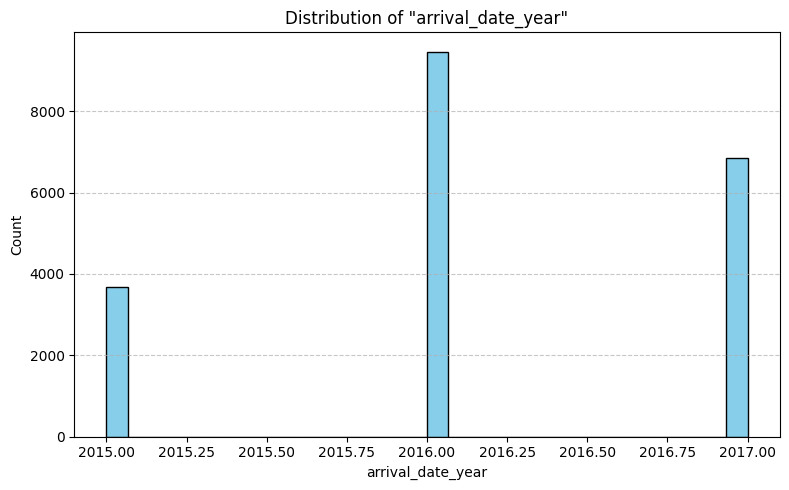

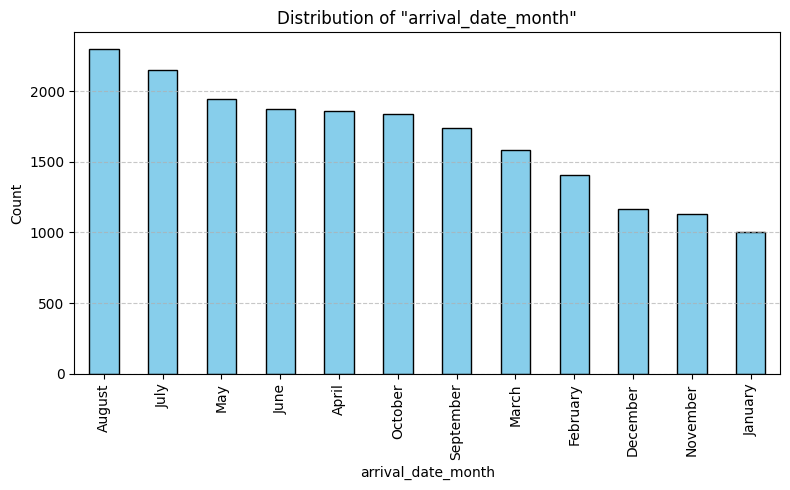

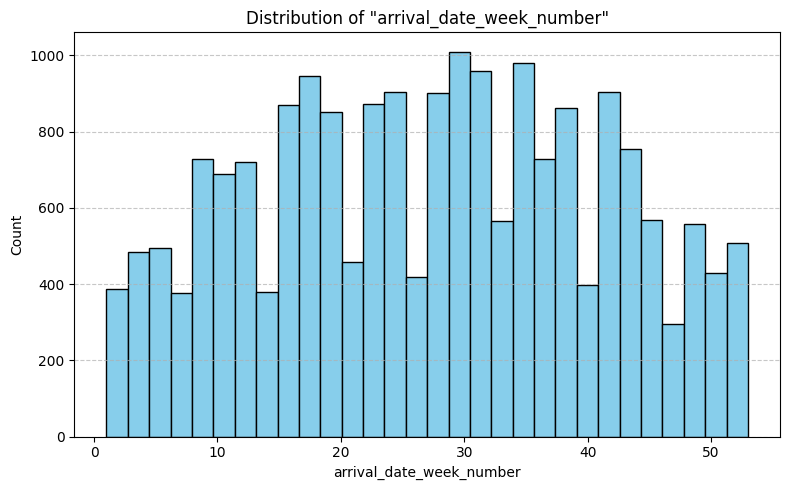

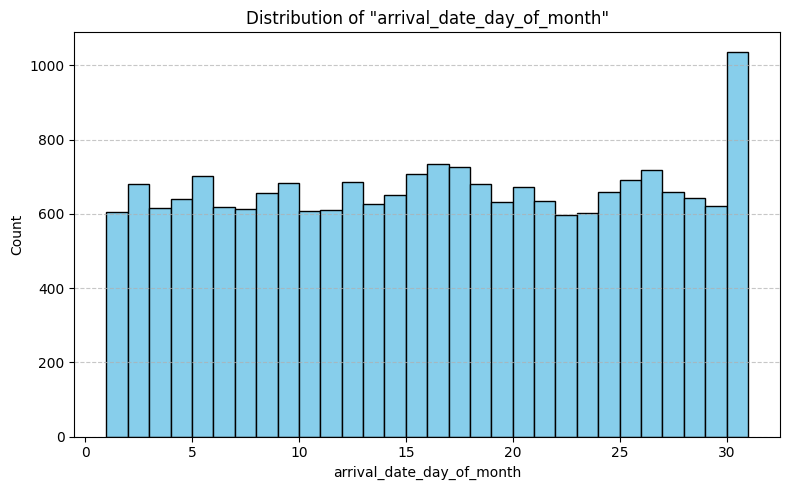

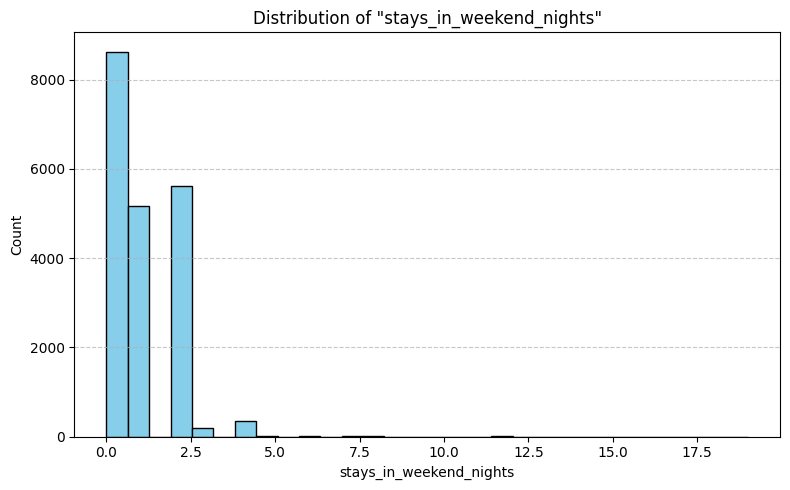

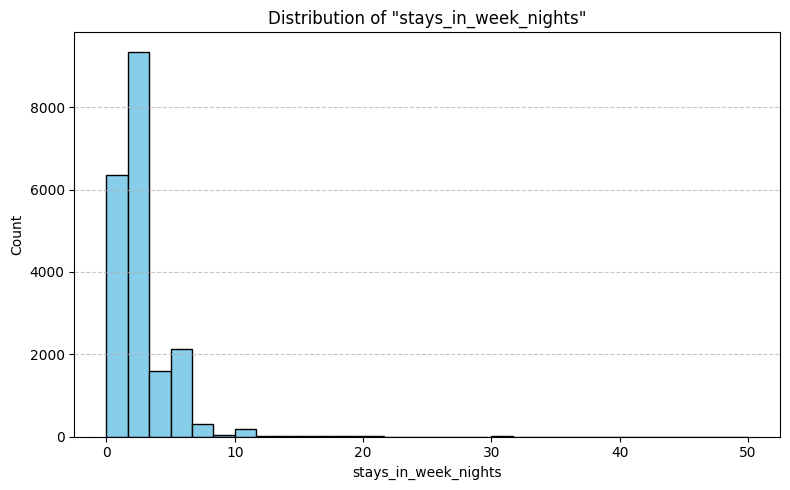

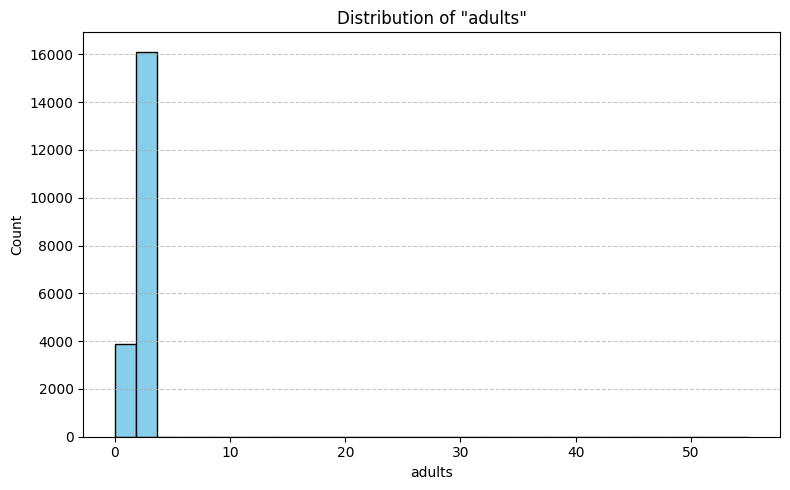

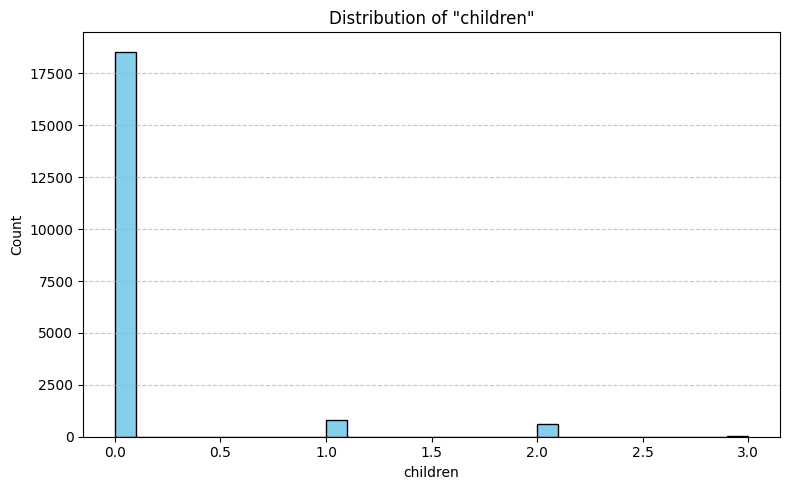

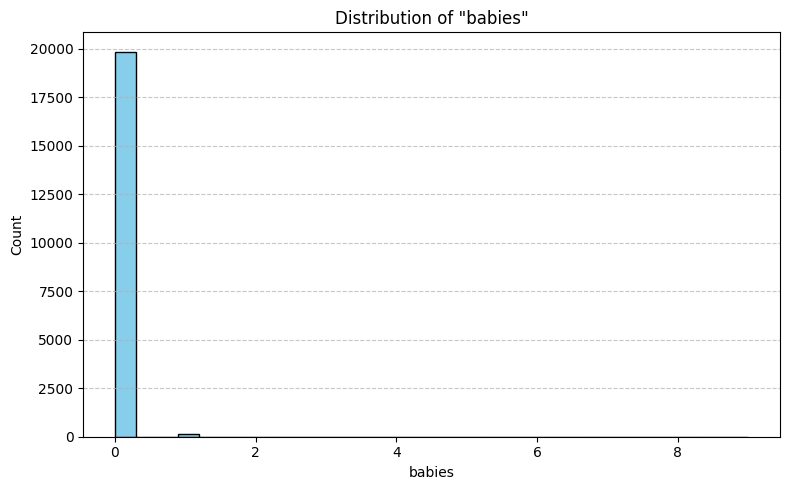

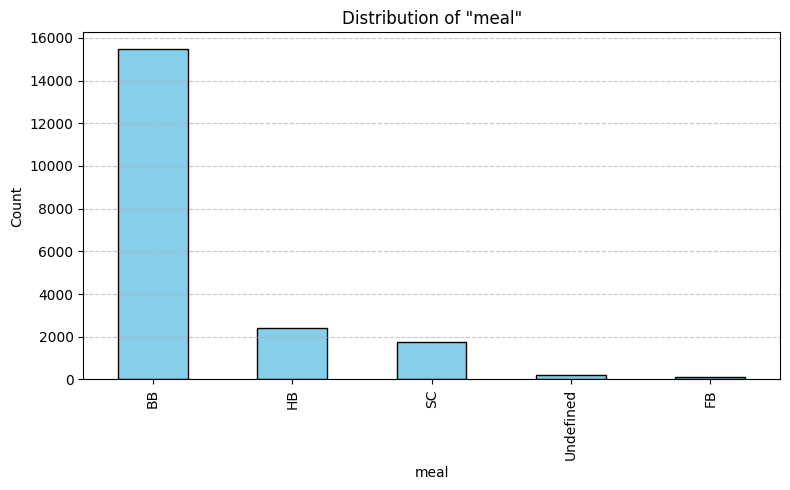

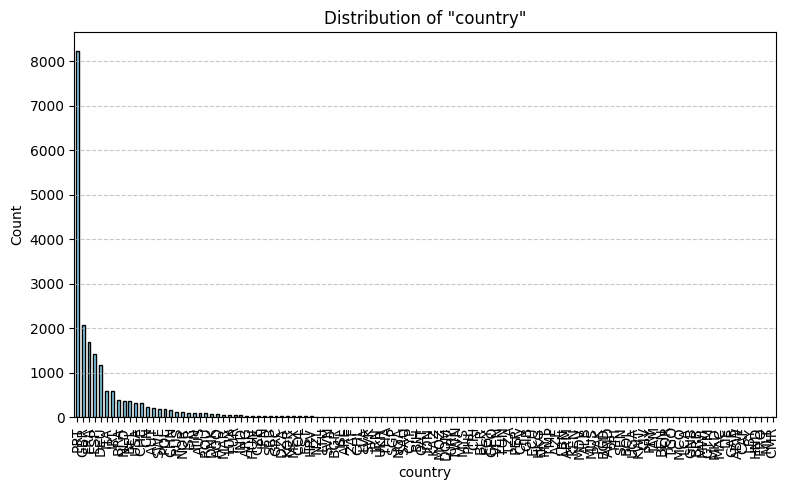

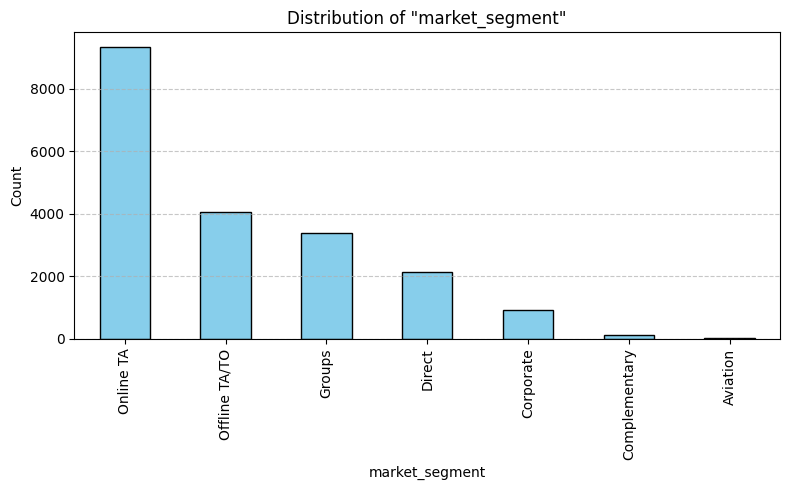

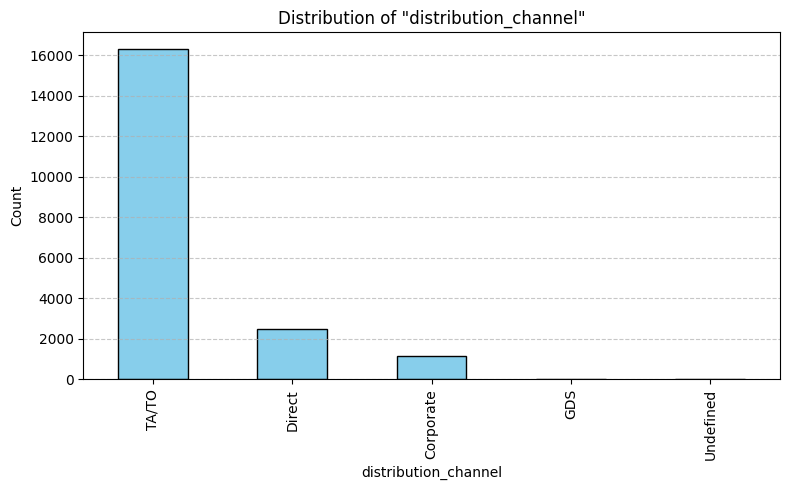

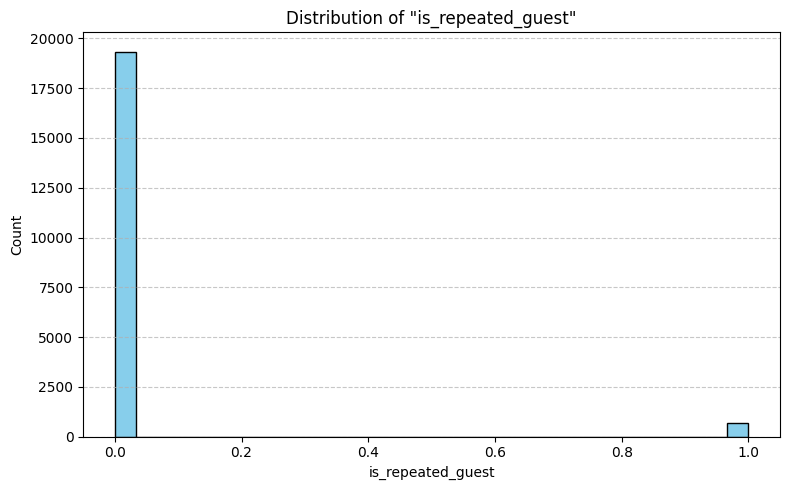

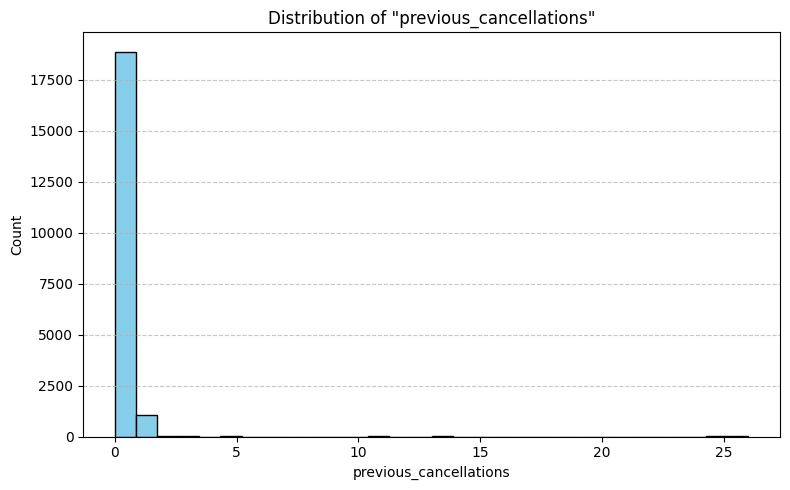

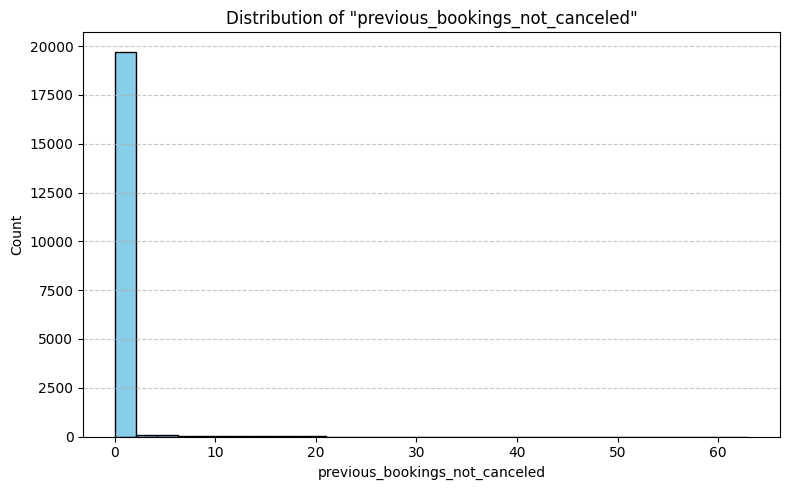

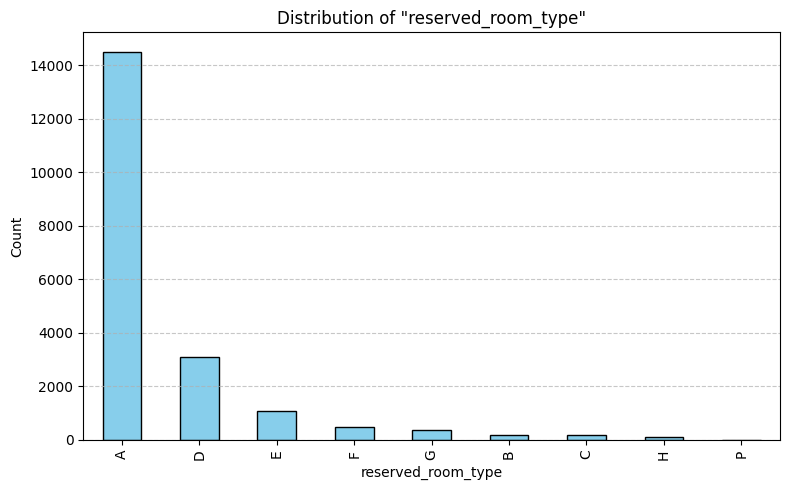

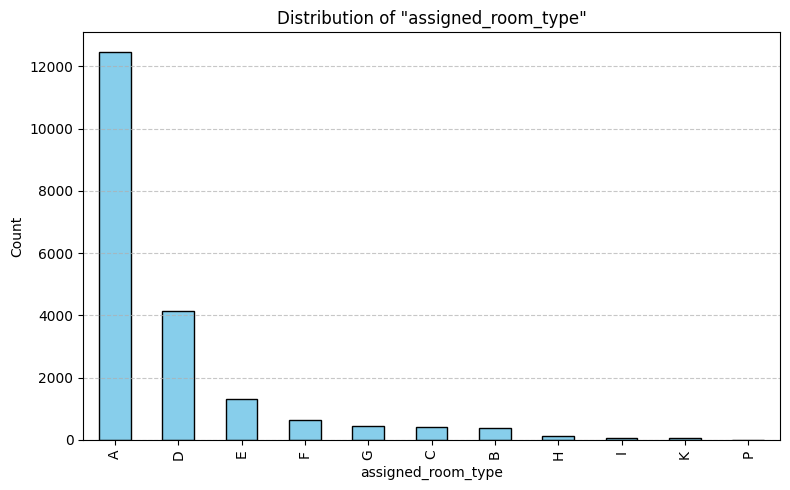

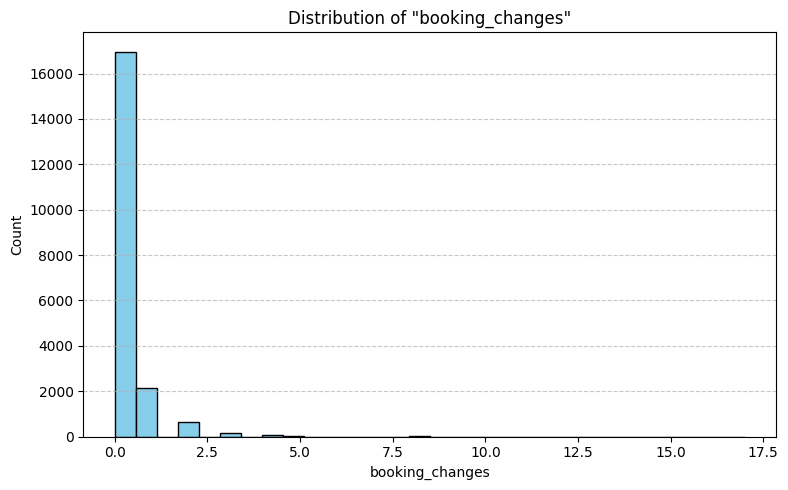

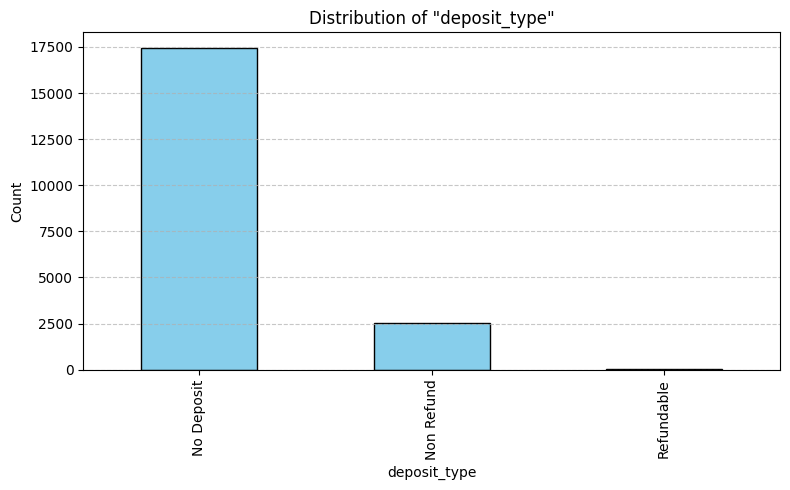

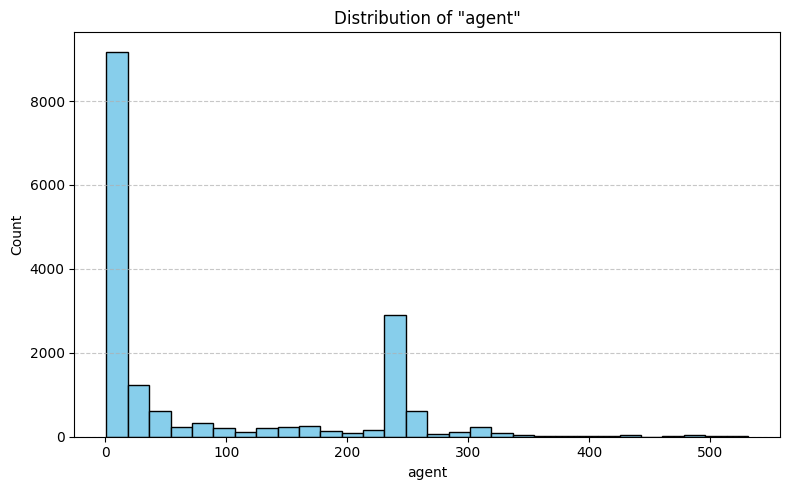

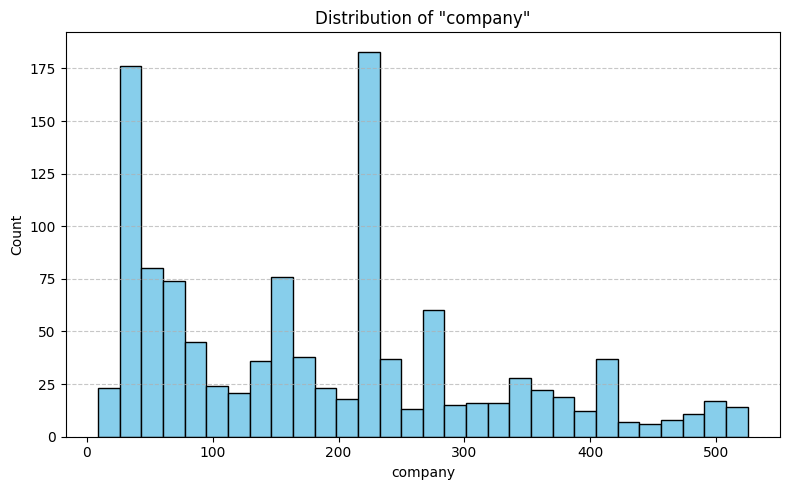

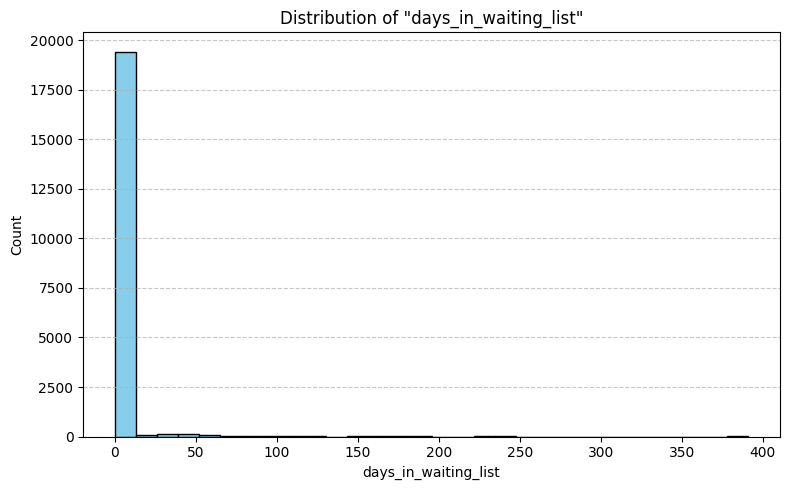

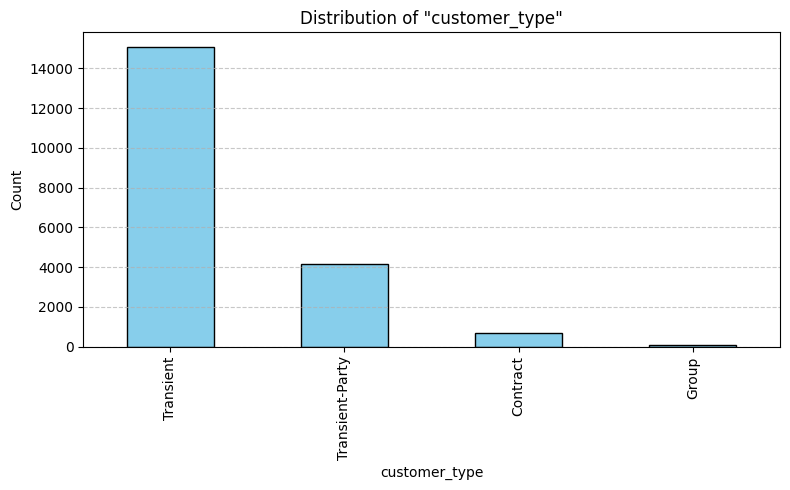

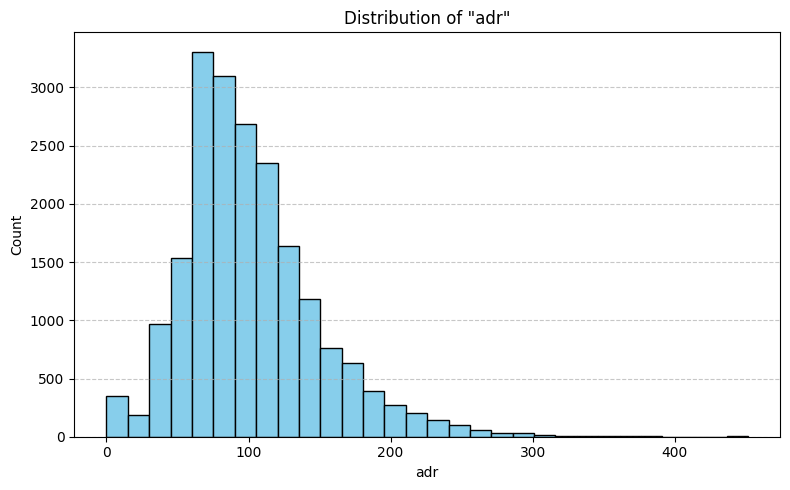

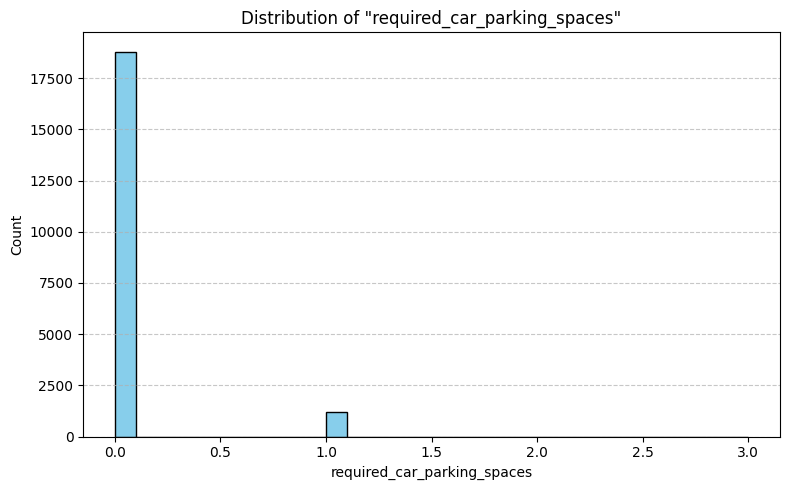

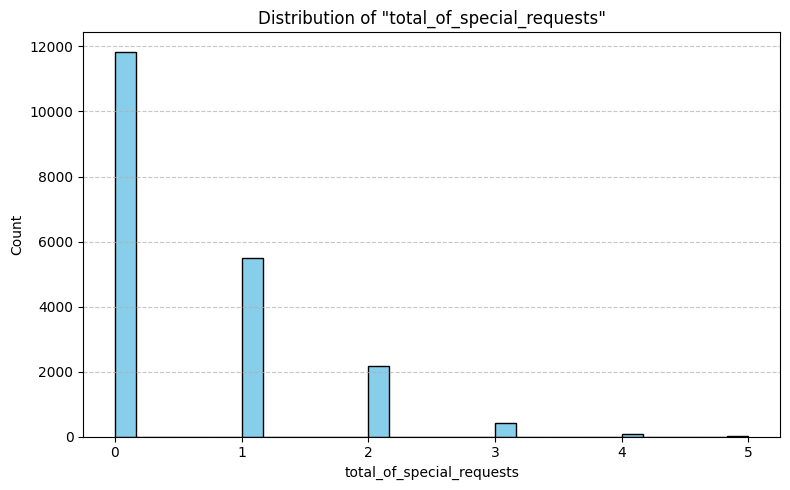

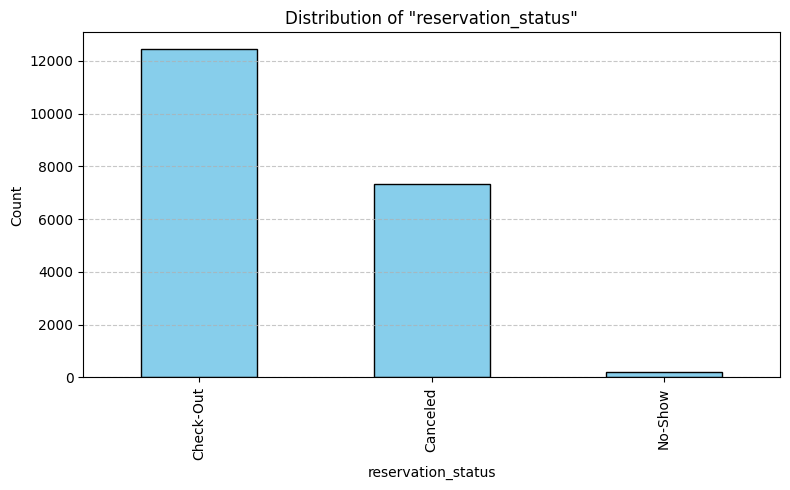

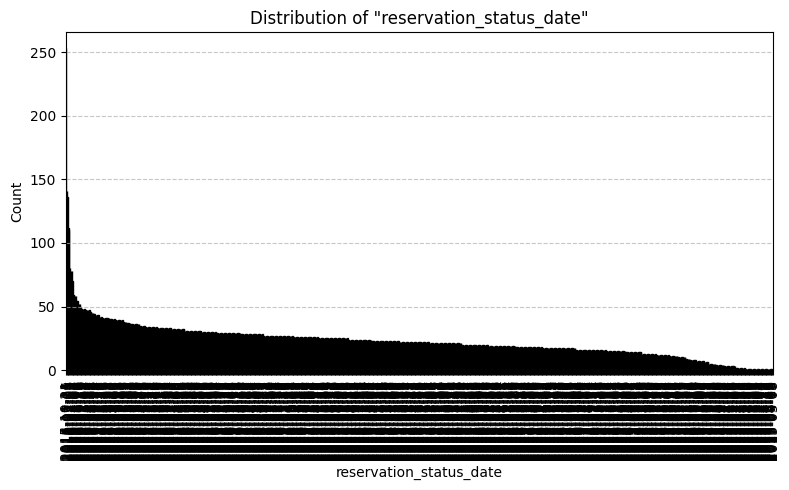

In [63]:
# Create distribution plots
for col in sample_df.columns:
    plt.figure(figsize=(8, 5))
    if sample_df[col].dtype == 'object':
        sample_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    else:
        sample_df[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of "{col}"')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#1 - Preparing the Data for Clustering

Encoding, cleaning, and standardizing the dataset to prepare it for clustering.

In [64]:
df_encoded = sample_df.copy()
label_encoders = {}

# Encoding categorical (object) columns
for col in sample_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(sample_df[col])
    label_encoders[col] = le  # For future use, if you want to reverse the transformation

label_col    = df_encoded['reservation_status']
print(label_col[:5])


0    1
1    0
2    1
3    1
4    1
Name: reservation_status, dtype: int64


Detect and Remove Problematic Features Before Dimensionality Reduction

Low variance features: ['babies', 'is_repeated_guest', 'required_car_parking_spaces']
babies                                0.011592
is_repeated_guest                     0.031913
required_car_parking_spaces           0.057223
deposit_type                          0.115754
children                              0.160127
hotel                                 0.224363
is_canceled                           0.234858
reservation_status                    0.248820
customer_type                         0.332968
adults                                0.395256
booking_changes                       0.419185
arrival_date_year                     0.501508
total_of_special_requests             0.637655
previous_cancellations                0.677131
distribution_channel                  0.838174
stays_in_weekend_nights               0.989597
meal                                  1.140611
market_segment                        1.615007
previous_bookings_not_canceled        2.467377
reserved_room_type   

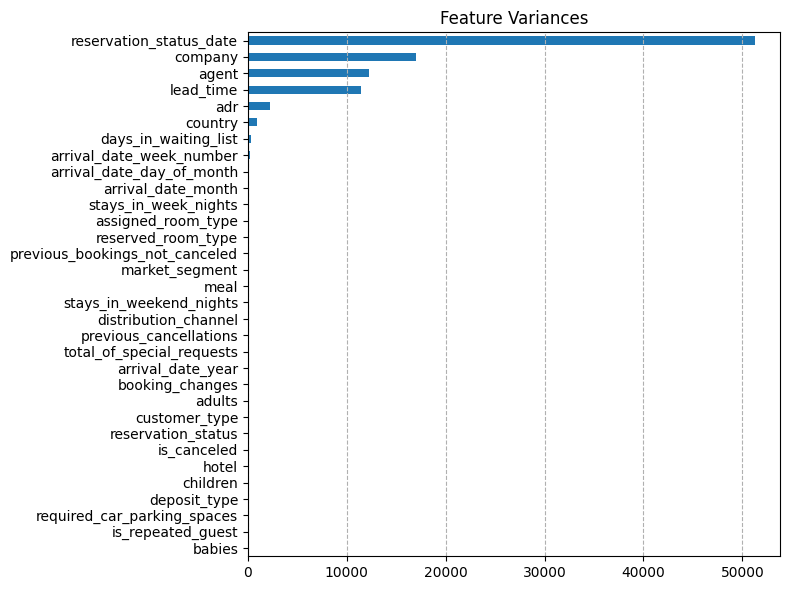

In [65]:
# Find features with low variance
low_var = df_encoded.var() < 0.1
print("Low variance features:", df_encoded.columns[low_var].tolist())

variances = df_encoded.var().sort_values()
print(variances)
variances.plot(kind='barh', figsize=(8, 6))
plt.title("Feature Variances")
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()


In [66]:
#Droping unwanted columns
columns_to_drop = [
    'reservation_status_date',
    'company',
    'agent',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'country',
    'previous_bookings_not_canceled',
    'days_in_waiting_list',
    'babies',
    'is_repeated_guest',
    'required_car_parking_spaces',
    'reservation_status'

]
df_encoded = df_encoded.drop(columns=[col for col in columns_to_drop if col in df_encoded.columns])
sample_df = sample_df.drop(columns=[col for col in columns_to_drop if col in sample_df.columns])
print(f"Currently working on a sample of {df_encoded.shape[0]} records and {df_encoded.shape[1]} columns.")
df_encoded.head()
print(df_encoded.shape)



Currently working on a sample of 20000 records and 19 columns.
(20000, 19)


In [67]:
# Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

from IPython.display import display
display(df_encoded.head(10))  # Displaying the first 10 rows in a clear table
print(type(scaled_data))

,hotel,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,distribution_channel,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,customer_type,adr,total_of_special_requests
0,1,203,49,2,2,5,2,0.0,0,3,1,0,5,5,4,0,2,66.80,0
1,0,82,29,16,0,3,2,0.0,0,6,3,0,0,0,0,0,2,76.50,0
2,0,25,53,27,0,3,3,0.0,0,5,3,0,0,9,2,0,3,60.00,1
3,0,1,11,9,0,1,1,0.0,0,6,3,0,0,0,0,0,3,95.00,0
4,0,70,16,16,2,2,2,0.0,3,6,3,0,0,0,0,0,2,108.00,0
5,0,170,17,27,0,3,2,0.0,0,6,3,0,3,3,0,0,2,130.50,0
6,0,21,10,4,0,1,1,0.0,0,6,3,0,0,0,0,0,3,85.00,0
7,0,102,42,16,0,2,2,0.0,2,5,3,0,0,3,0,0,3,109.00,0
8,1,55,47,19,2,5,2,0.0,2,6,3,0,3,3,1,0,2,67.44,0
9,1,222,38,14,1,1,2,0.0,2,4,3,0,0,0,0,0,2,80.00,0


<class 'numpy.ndarray'>


#2 - What is the best way to do dimension reduction

##PCA

Silhouette Score for 2 clusters: 0.4370953719631315
Silhouette Score for 3 clusters: 0.4793068009054496
Silhouette Score for 4 clusters: 0.3754509390442336
Silhouette Score for 5 clusters: 0.39272875141499364
Silhouette Score for 6 clusters: 0.39936063059329197
Silhouette Score for 7 clusters: 0.40725478239109736
Silhouette Score for 8 clusters: 0.3753471949774969
Silhouette Score for 9 clusters: 0.3698170816394248
Silhouette Score for 10 clusters: 0.3721758762047715
Silhouette Score for 11 clusters: 0.36457804824096074
Silhouette Score for 12 clusters: 0.3671981642481328
Silhouette Score for 13 clusters: 0.34760178935930763
Silhouette Score for 14 clusters: 0.34905417466753424
Silhouette Score for 15 clusters: 0.3478775101877674
Silhouette Score for 16 clusters: 0.34740463730458837


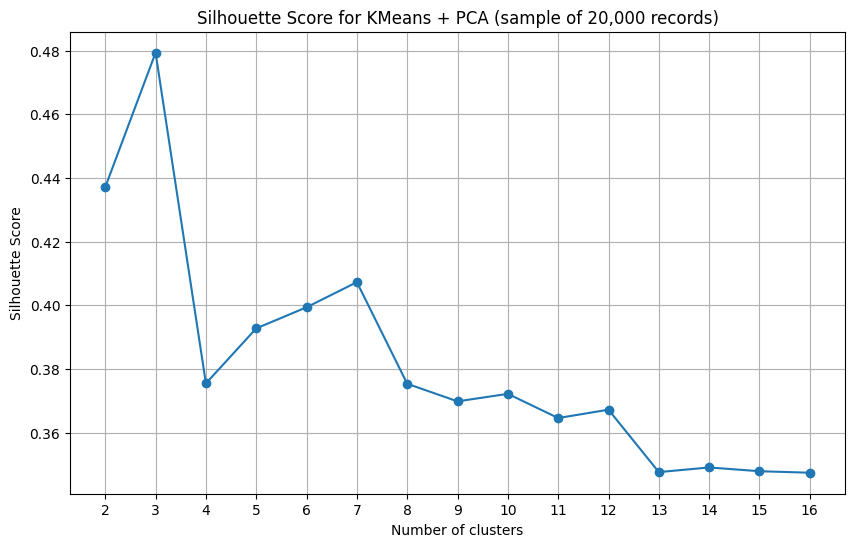

In [68]:
# Data processing, clustering, and Silhouette Score visualization for PCA
# Dimensionality reduction with PCA to 2 dimensions
pca = PCA(n_components=2)
pca_reduced_data = pca.fit_transform(scaled_data)

# Running KMeans with a varying number of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_reduced_data)
    score = silhouette_score(pca_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Displaying the Silhouette Score plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + PCA (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save as vector graphics
plt.savefig("PCA_silhouette_score_plot.pdf")  # Save as PDF
plt.show()


##ICA

Silhouette Score for 2 clusters: 0.4703397351374298
Silhouette Score for 3 clusters: 0.4790713862349498
Silhouette Score for 4 clusters: 0.4587226867883041
Silhouette Score for 5 clusters: 0.3721733877178704
Silhouette Score for 6 clusters: 0.385599983952309
Silhouette Score for 7 clusters: 0.3991917276857206
Silhouette Score for 8 clusters: 0.39475626937169017
Silhouette Score for 9 clusters: 0.3783391379548878
Silhouette Score for 10 clusters: 0.34918963703928385
Silhouette Score for 11 clusters: 0.3515127206314003
Silhouette Score for 12 clusters: 0.3524534347030786
Silhouette Score for 13 clusters: 0.3483540125372383
Silhouette Score for 14 clusters: 0.33389103420157507
Silhouette Score for 15 clusters: 0.3433196059963323
Silhouette Score for 16 clusters: 0.33939838124192545


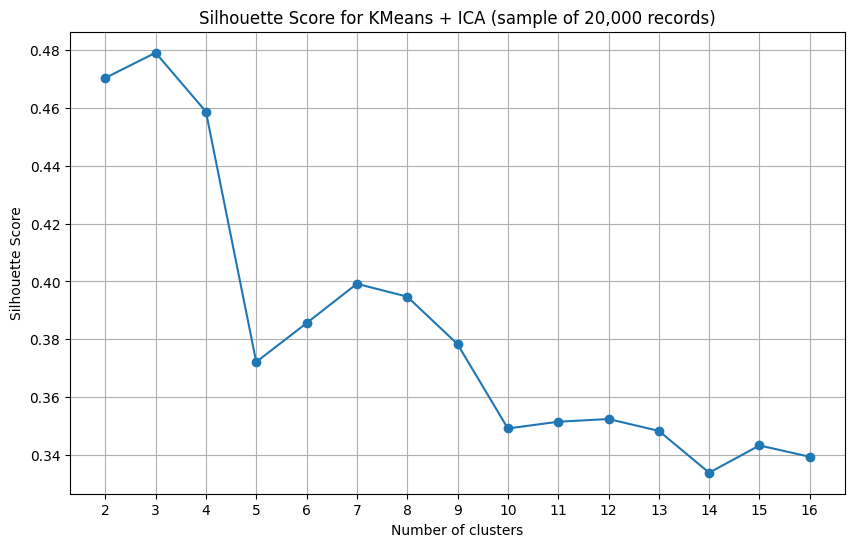

In [69]:
# Filter out columns with zero variance
variances = scaled_data.var(axis=0)
non_zero_var_indices = np.where(variances > 1e-10)[0]
ica_scaled_data = scaled_data[:, non_zero_var_indices]

# Ensure no NaN or infinite values
ica_scaled_data = np.nan_to_num(ica_scaled_data, nan=0.0, posinf=0.0, neginf=0.0)

# Dimensionality reduction with ICA to 2 components
ica = FastICA(n_components=2, random_state=42)
ica_reduced_data = ica.fit_transform(ica_scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(ica_reduced_data)
    score = silhouette_score(ica_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + ICA (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("ICA_silhouette_score_plot.pdf")

plt.show()


##TSNE

C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Silhouette Score for 2 clusters: 0.3405483663082123
Silhouette Score for 3 clusters: 0.3750371038913727
Silhouette Score for 4 clusters: 0.36581069231033325
Silhouette Score for 5 clusters: 0.3546244204044342
Silhouette Score for 6 clusters: 0.34933021664619446
Silhouette Score for 7 clusters: 0.37576955556869507
Silhouette Score for 8 clusters: 0.3719029128551483
Silhouette Score for 9 clusters: 0.3719523549079895
Silhouette Score for 10 clusters: 0.3633703589439392
Silhouette Score for 11 clusters: 0.3780894875526428
Silhouette Score for 12 clusters: 0.3855729103088379
Silhouette Score for 13 clusters: 0.3916456997394562
Silhouette Score for 14 clusters: 0.3836880624294281
Silhouette Score for 15 clusters: 0.3700830936431885
Silhouette Score for 16 clusters: 0.36668941378593445


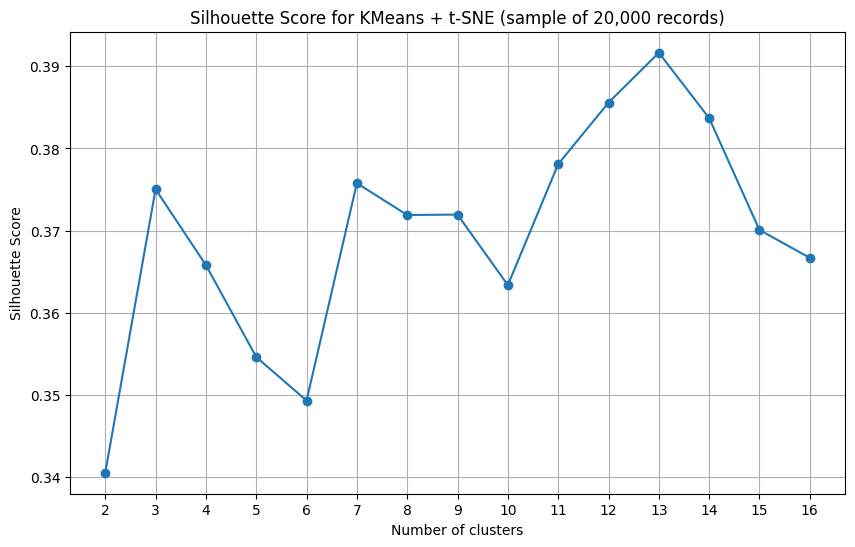

In [70]:
# Dimensionality reduction with t-SNE to 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
tsne_reduced_data = tsne.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tsne_reduced_data)
    score = silhouette_score(tsne_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + t-SNE (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("TSNE_silhouette_score_plot.pdf")

plt.show()


##ISOMAP

In [ ]:
# Dimensionality reduction with Isomap to 2 components
isomap = Isomap(n_components=2)
isomap_reduced_data = isomap.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters_test in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters_test, random_state=42)
    cluster_labels = kmeans.fit_predict(isomap_reduced_data)
    score = silhouette_score(isomap_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Find and store the optimal number of clusters
best_n_clusters = cluster_counts[np.argmax(silhouette_values)]
print(f"Optimal number of clusters based on Silhouette Score: {best_n_clusters}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + Isomap (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("Isomap_silhouette_score_plot.pdf")

plt.show()

C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 139 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)


##UMAP

C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\Menashe Lorenzi\AppDa

Silhouette Score for 2 clusters: 0.4002278745174408
Silhouette Score for 3 clusters: 0.37235963344573975
Silhouette Score for 4 clusters: 0.40609627962112427
Silhouette Score for 5 clusters: 0.4134180247783661
Silhouette Score for 6 clusters: 0.4041869640350342
Silhouette Score for 7 clusters: 0.45379510521888733
Silhouette Score for 8 clusters: 0.4801867604255676
Silhouette Score for 9 clusters: 0.5017313361167908
Silhouette Score for 10 clusters: 0.5063295364379883
Silhouette Score for 11 clusters: 0.5030650496482849
Silhouette Score for 12 clusters: 0.49283072352409363
Silhouette Score for 13 clusters: 0.5106646418571472
Silhouette Score for 14 clusters: 0.5232553482055664
Silhouette Score for 15 clusters: 0.4963761270046234
Silhouette Score for 16 clusters: 0.5085513591766357


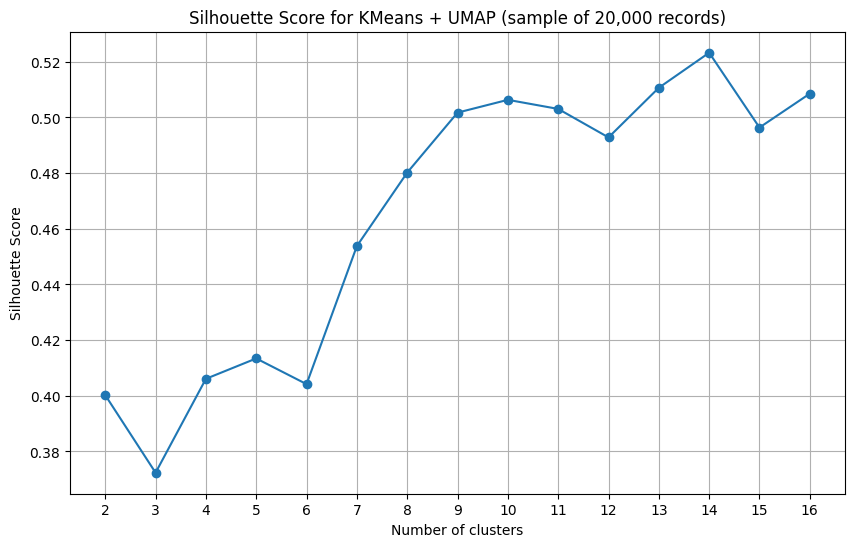

In [ ]:
# Dimensionality reduction with UMAP to 2 components
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_reduced_data = umap_reducer.fit_transform(scaled_data)

# Run KMeans with varying numbers of clusters using Silhouette Score
cluster_counts = list(range(2, 17))
silhouette_values = []

for n_clusters in cluster_counts:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_reduced_data)
    score = silhouette_score(umap_reduced_data, cluster_labels)
    silhouette_values.append(score)
    print(f"Silhouette Score for {n_clusters} clusters: {score}")

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, silhouette_values, marker='o')
plt.title('Silhouette Score for KMeans + UMAP (sample of 20,000 records)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_counts)
plt.grid(True)

# Save the figure as a vector graphic
plt.savefig("UMAP_silhouette_score_plot.pdf")

plt.show()


# 3 - Clustering with Standard Methods


In [ ]:
pip install igraph leidenalg

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB 640.0 kB/s eta 0:00:04
    --------------------------------------- 0.0/2.0 MB 487.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/2.0 MB 837.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.0 MB 1.1 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/2.0 MB 1.5 MB/s eta 0:00:02
   --------- ------------------------------ 0.5/2.0 MB 1.7 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/2.0 MB 1.7 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/2.0 MB 2.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/2.0 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/2.0 MB 2.2 MB/s eta 0:00:01
   ----------------------- ---------------- 1.1/2.0 MB 2.3 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 2.4 MB/s eta 0:00:01
   ----------


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Menashe Lorenzi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


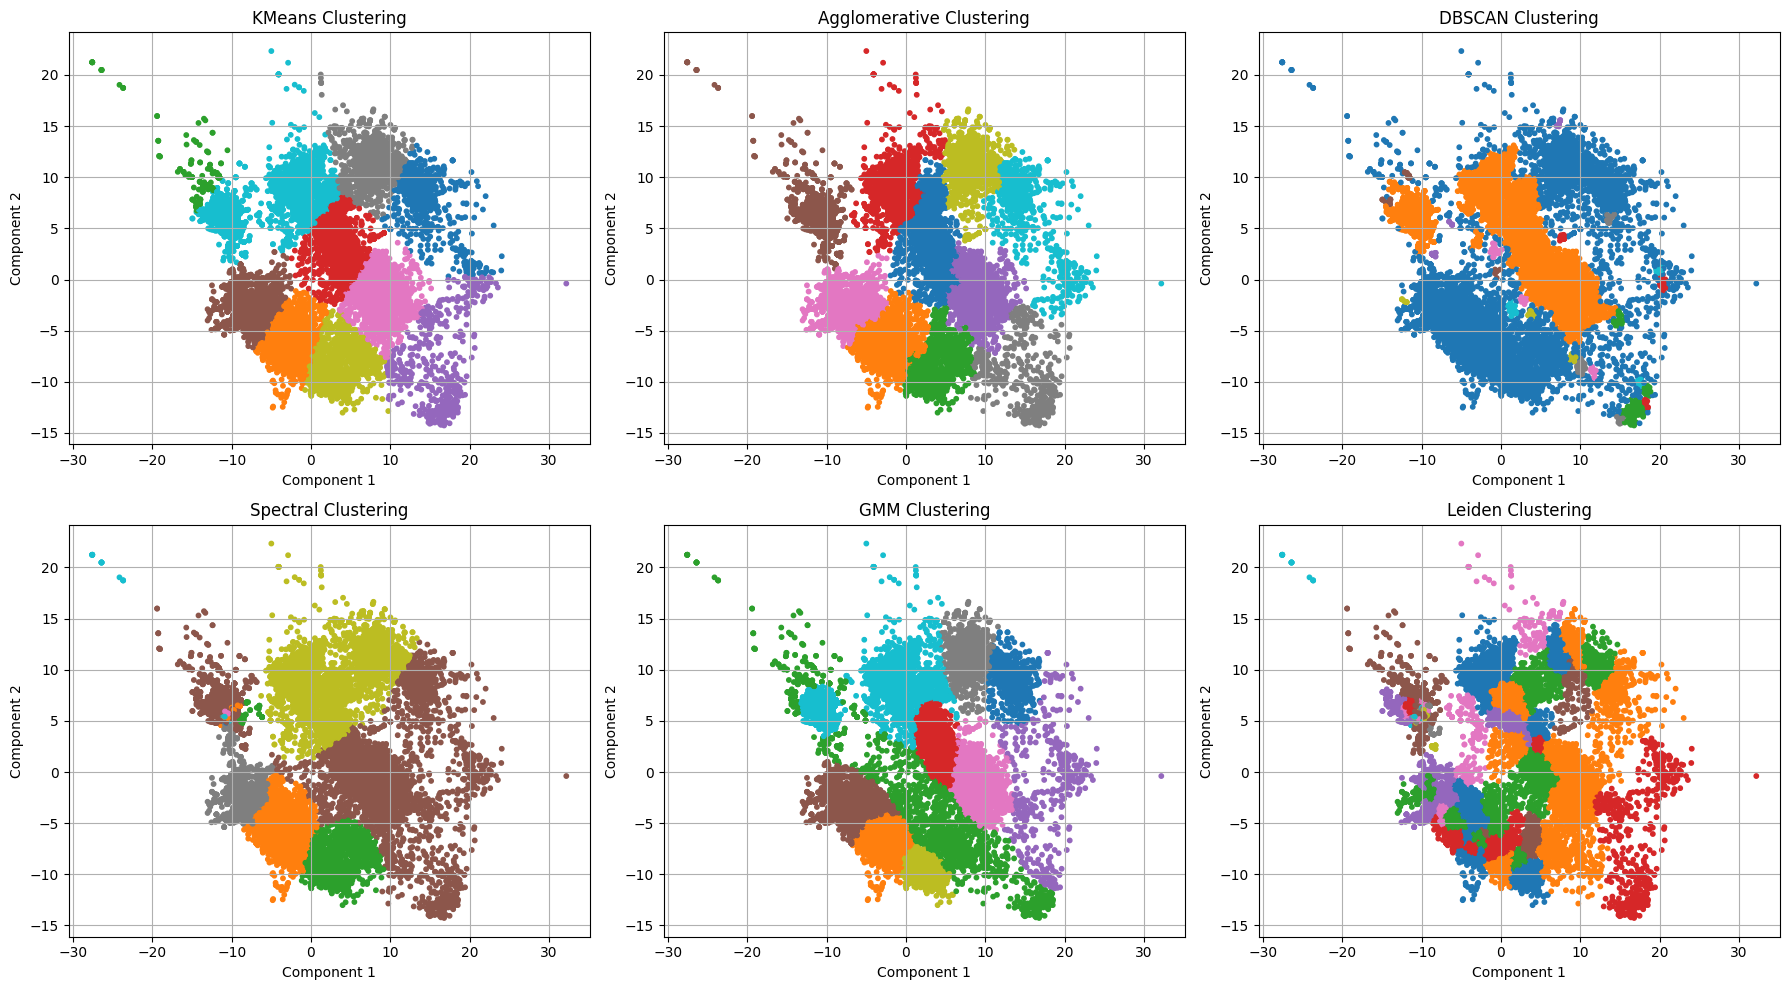

  Clustering Method  Silhouette Score
0            KMeans          0.538057
1     Agglomerative          0.536648
4               GMM          0.467569
5            Leiden          0.193994
3          Spectral          0.136099
2            DBSCAN         -0.040016


C:\Users\Menashe Lorenzi\AppData\Local\Temp\ipykernel_28104\3238608761.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=silhouette_df, x='Silhouette Score', y='Clustering Method', palette='viridis')


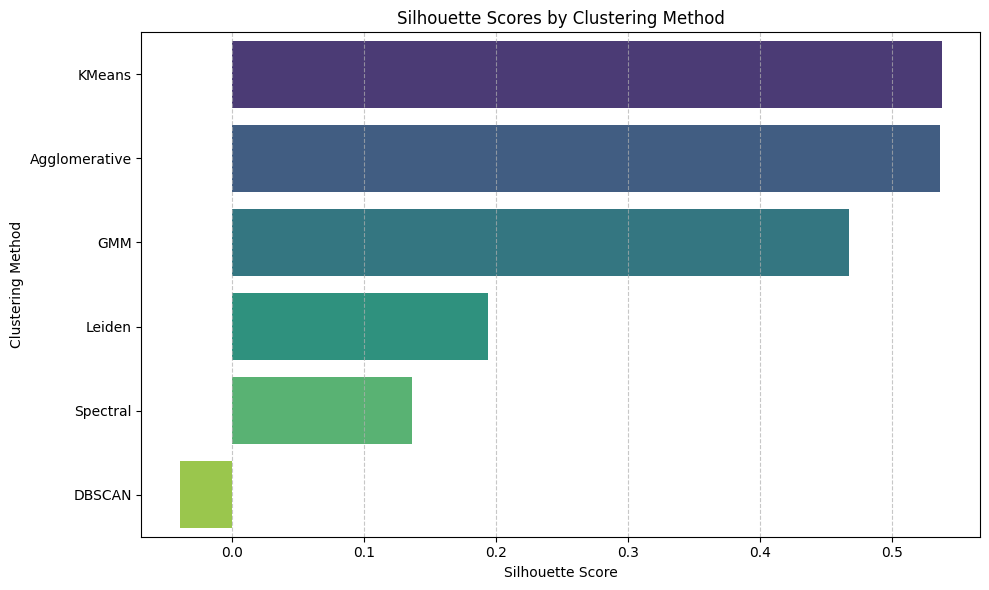

In [ ]:

reduced_data = isomap_reduced_data
n_clusters = best_n_clusters

# KMeans
kmeans = KMeans(n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters)
agg_labels = agg.fit_predict(reduced_data)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(reduced_data)

# Spectral Clustering
spectral = SpectralClustering(n_clusters, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(reduced_data)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(reduced_data)

# ========== Leiden Clustering ==========

import igraph as ig
import leidenalg
from sklearn.neighbors import kneighbors_graph

# Build a KNN graph
knn_graph = kneighbors_graph(reduced_data, n_neighbors=10, include_self=False)
sources, targets = knn_graph.nonzero()
edges = list(zip(sources.tolist(), targets.tolist()))

# Create igraph graph
g = ig.Graph(edges=edges, directed=False)
g.vs["name"] = list(range(reduced_data.shape[0]))

# Run Leiden
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
leiden_labels = np.array(partition.membership)



cluster_results = {
    "KMeans": kmeans_labels,
    "Agglomerative": agg_labels,
    "DBSCAN": dbscan_labels,
    "Spectral": spectral_labels,
    "GMM": gmm_labels,
    "Leiden": leiden_labels
}

# Define color map
cmap = 'tab10'

# Create grid of scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (method, labels) in enumerate(cluster_results.items()):
    ax = axes[i]
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=cmap, s=10)
    ax.set_title(f"{method} Clustering")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("clustering_results.pdf")
plt.show()

# Compute Silhouette Scores
silhouette_scores = {}
for method, labels in cluster_results.items():
    if method == "DBSCAN" and (len(set(labels)) <= 1 or -1 not in labels):
        silhouette_scores[method] = np.nan
    else:
        if method == "DBSCAN":
            mask = labels != -1
            score = silhouette_score(reduced_data[mask], np.array(labels)[mask])
        else:
            score = silhouette_score(reduced_data, labels)
        silhouette_scores[method] = score

# Convert to DataFrame
silhouette_df = pd.DataFrame({
    'Clustering Method': list(silhouette_scores.keys()),
    'Silhouette Score': list(silhouette_scores.values())
}).sort_values(by='Silhouette Score', ascending=False)
print(silhouette_df)
# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
sns.barplot(data=silhouette_df, x='Silhouette Score', y='Clustering Method', palette='viridis')
plt.title('Silhouette Scores by Clustering Method')
plt.xlabel('Silhouette Score')
plt.ylabel('Clustering Method')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("silhouette_plot.pdf")
plt.show()


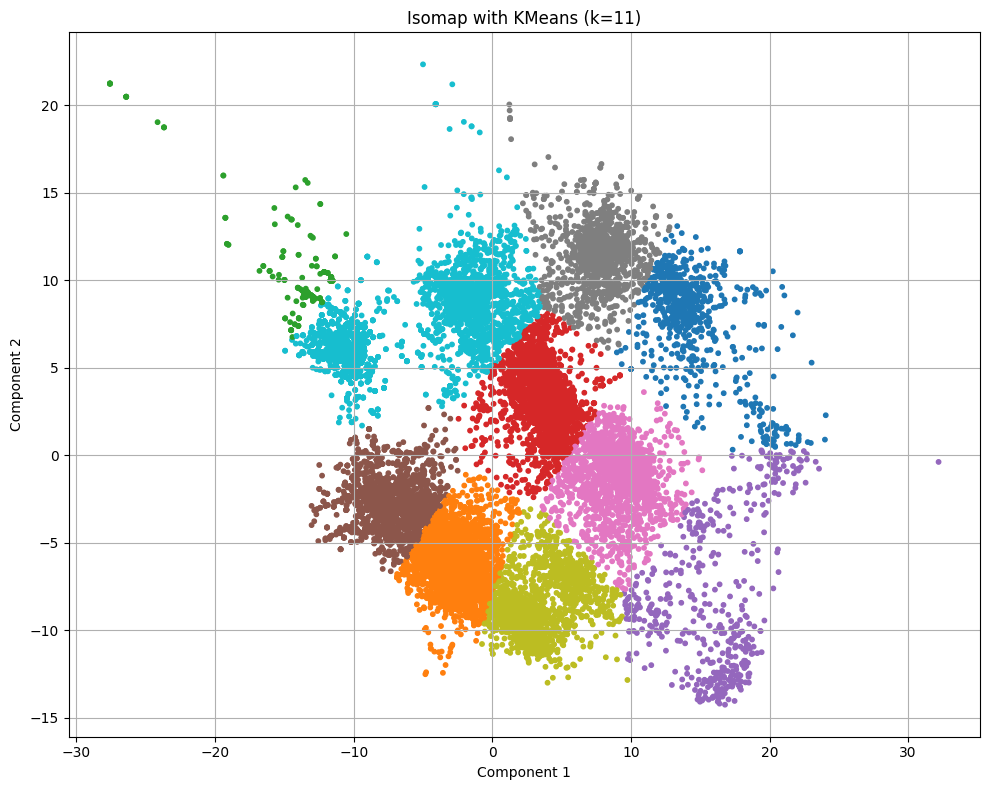

In [ ]:
# Fit KMeans again on both reduced spaces using best_n_clusters
kmeans_isomap = KMeans(n_clusters=best_n_clusters, random_state=42)
labels_isomap = kmeans_isomap.fit_predict(isomap_reduced_data)

# Plot Isomap clustering result
plt.figure(figsize=(10, 8))
plt.scatter(isomap_reduced_data[:, 0], isomap_reduced_data[:, 1], c=labels_isomap, cmap='tab10', s=10)
plt.title(f'Isomap with KMeans (k={best_n_clusters})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)


plt.tight_layout()
plt.savefig("Isomap_kmeans_cluster.pdf")
plt.show()


# 4 - Finding the Most Influential Feature for Clustering

🧪 Mutual Information for Feature Importance
We use Mutual Information (MI) and Normalized Mutual Information (NMI) to evaluate how much information a categorical feature shares with the cluster labels.

Unlike linear methods (e.g., ANOVA), MI does not assume linear relationships and is well-suited for complex, non-linear data structures — such as those produced by dimensionality reduction methods like UMAP or t-SNE.

This makes MI a robust and flexible choice for identifying which categorical features are most informative in distinguishing between clusters.



                      Feature         Type  Mutual Information
17                        adr    Numerical            0.639408
2              market_segment  Categorical            0.601201
0                       hotel  Categorical            0.443698
4          reserved_room_type  Categorical            0.424701
5          assigned_room_type  Categorical            0.374344
3        distribution_channel  Categorical            0.360208
6                deposit_type  Categorical            0.333671
8                   lead_time    Numerical            0.280109
7               customer_type  Categorical            0.177447
1                        meal  Categorical            0.133498
14                   children    Numerical            0.131199
18  total_of_special_requests    Numerical            0.114759
12       stays_in_week_nights    Numerical            0.094569
13                     adults    Numerical            0.075442
15     previous_cancellations    Numerical            0

C:\Users\Menashe Lorenzi\AppData\Local\Temp\ipykernel_28104\2005145767.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Mutual Information', y='Feature', palette=palette)


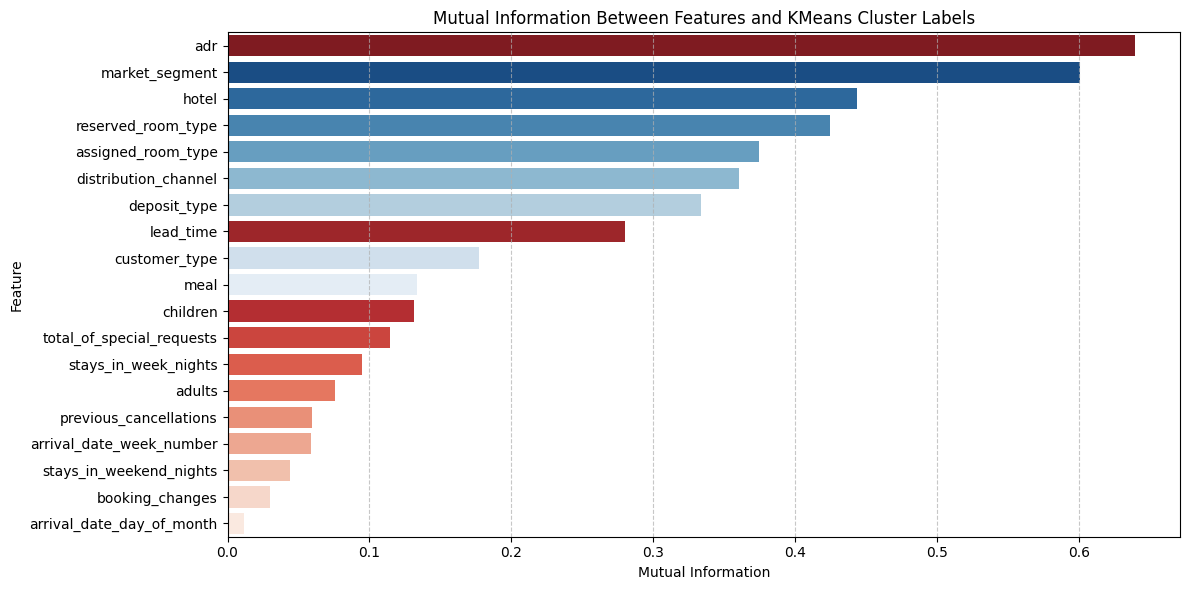

In [ ]:
df = sample_df.copy()


df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Missing')


for col in df.select_dtypes(include='number').columns:
    df[col] = df[col].fillna(df[col].median())


categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols   = [c for c in df.select_dtypes(include='number').columns
                    if c != 'cluster']


results = []


for col in categorical_cols:
    mi = mutual_info_score(df[col], kmeans_labels)
    results.append({'Feature': col, 'Type': 'Categorical', 'Mutual Information': mi})


mi_numeric = mutual_info_classif(df[numerical_cols], kmeans_labels, random_state=42)
for col, mi in zip(numerical_cols, mi_numeric):
    results.append({'Feature': col, 'Type': 'Numerical', 'Mutual Information': mi})


results_df = (pd.DataFrame(results)
              .sort_values(by='Mutual Information', ascending=False))


results_df = results_df[results_df['Feature'] != 'cluster']
print(results_df)

palette_cat = sns.color_palette("Blues",  n_colors=results_df.Type.eq('Categorical').sum())[::-1]
palette_num = sns.color_palette("Reds",   n_colors=results_df.Type.eq('Numerical').sum())[::-1]
palette = []
for _, row in results_df.iterrows():
    if row['Type']=='Categorical': palette.append(palette_cat.pop(0))
    else:                        palette.append(palette_num.pop(0))

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Mutual Information', y='Feature', palette=palette)
plt.title('Mutual Information Between Features and KMeans Cluster Labels')
plt.xlabel('Mutual Information'); plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("mutual_information_plot.pdf")
plt.show()


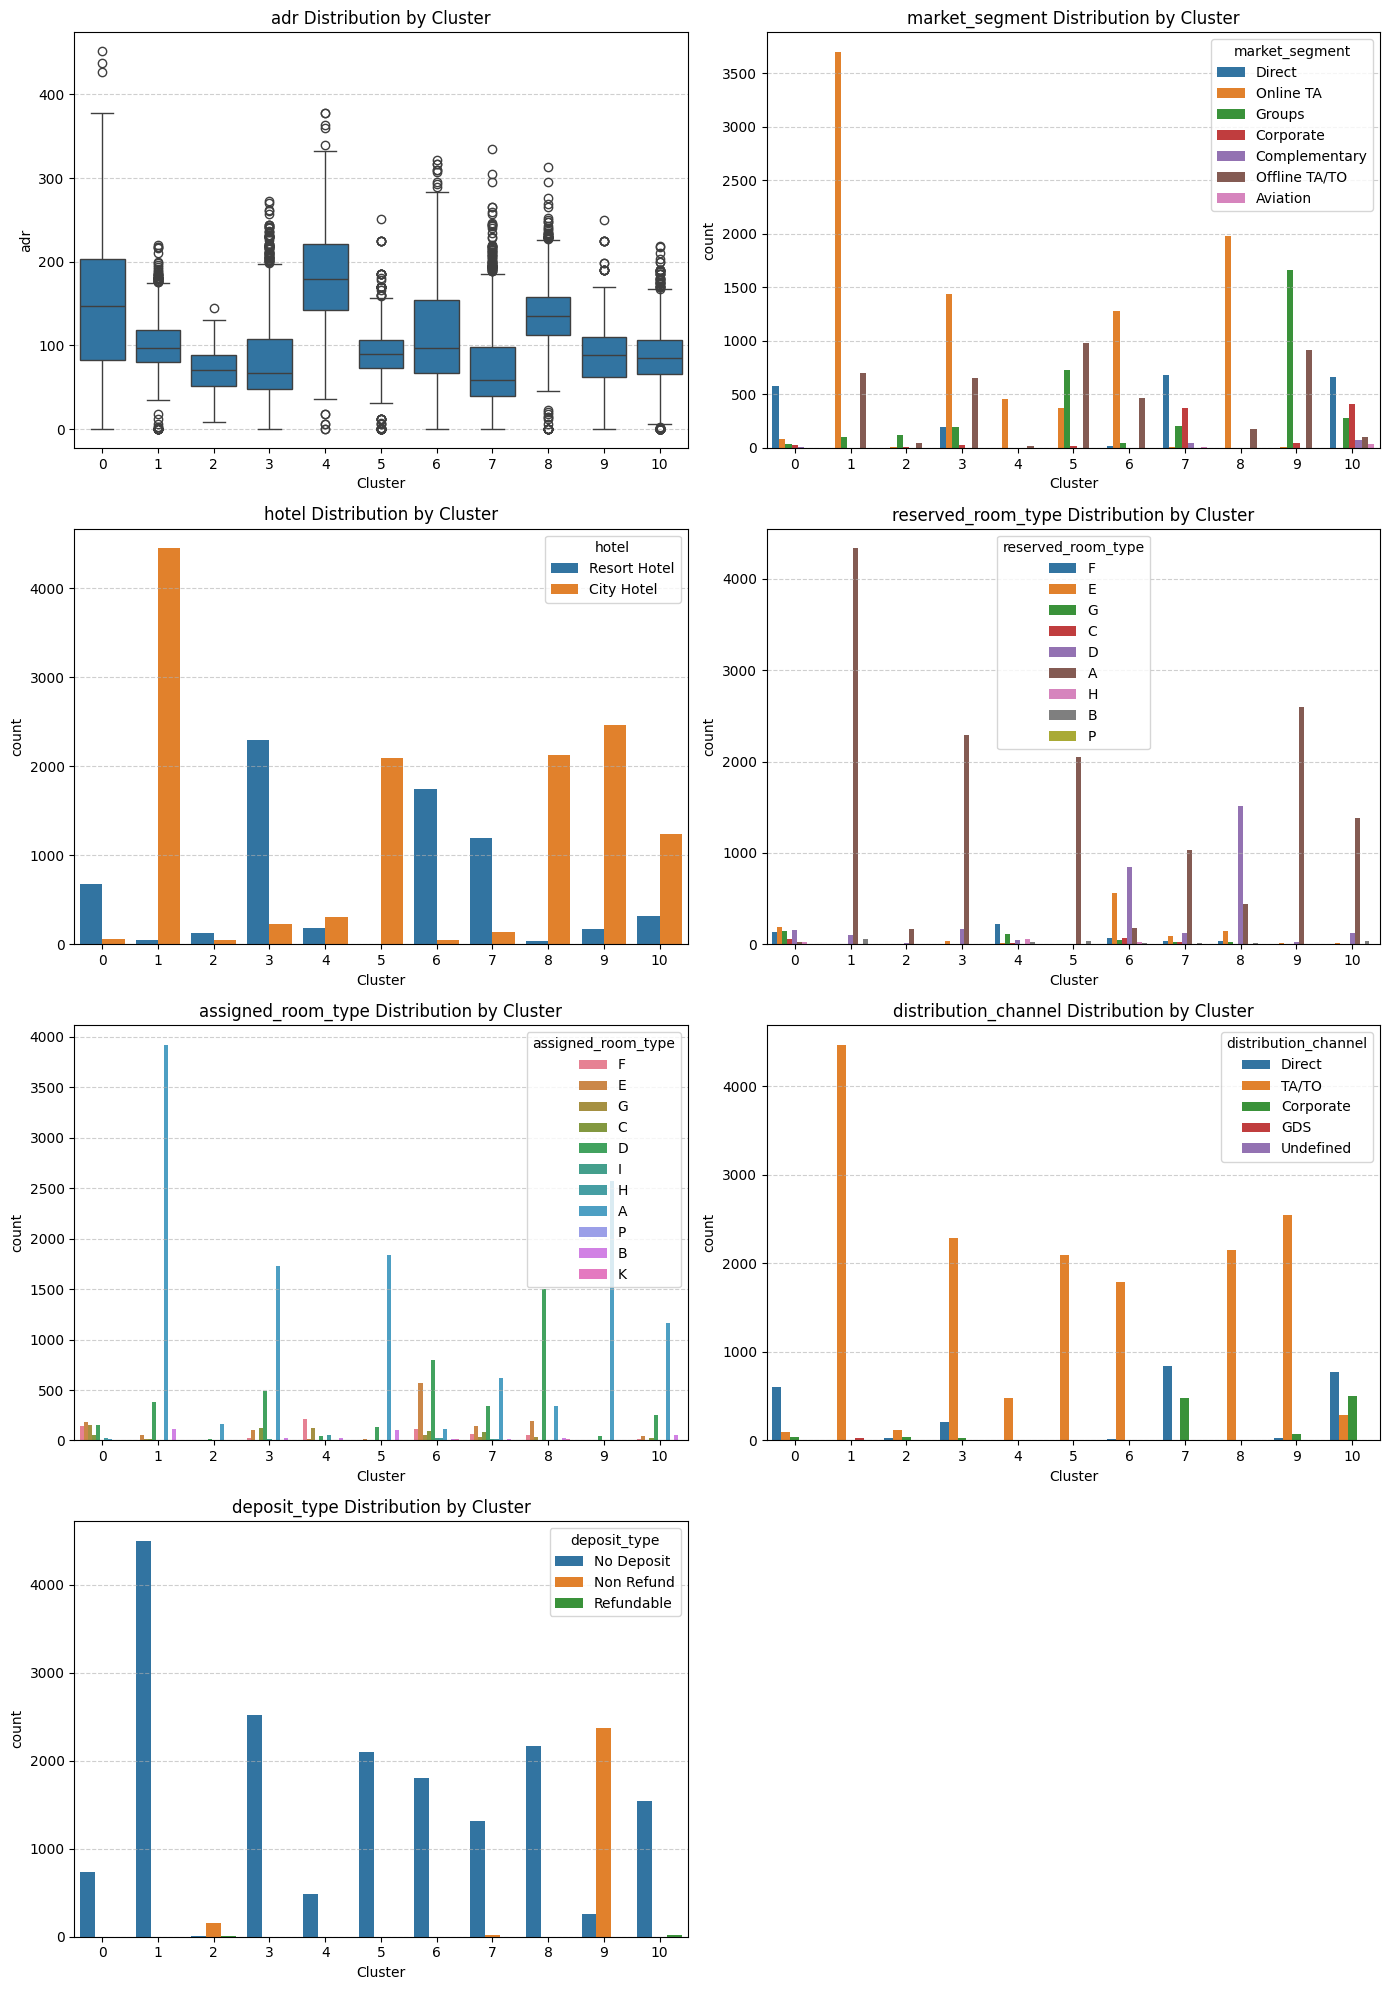

In [ ]:
top_features = ['adr', 'market_segment', 'hotel', 'reserved_room_type','assigned_room_type','distribution_channel','deposit_type']

n_cols = 2
n_rows = (len(top_features) + 1) // n_cols
sample_df['cluster'] = kmeans.labels_
plt.figure(figsize=(14, 5 * n_rows))

for i, feature in enumerate(top_features, 1):
    plt.subplot(n_rows, n_cols, i)

    if sample_df[feature].dtype == 'object' or sample_df[feature].nunique() < 15:
        # categorical
        sns.countplot(data=sample_df, x='cluster', hue=feature)
        plt.legend(title=feature)
    else:
        # numeric
        sns.boxplot(data=sample_df, x='cluster', y=feature)

    plt.title(f"{feature} Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("cluster_distributions.pdf")
plt.show()


# 5 - Define Each Cluster

In [ ]:
sample_df['reservation_status'] = label_col

#  Contingency table
ct = pd.crosstab(sample_df['cluster'], sample_df['reservation_status'])
print("Contingency table:\n", ct, "\n")

#  Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi2 = {chi2:.2f}, p-value = {p:.2e}, dof = {dof}\n")

#  Cramér’s V
n = sample_df.shape[0]
min_dim = min(ct.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramér’s V = {cramers_v:.3f}\n")

#  Agreement metrics between the true labels and the cluster labels
ari = adjusted_rand_score(sample_df['reservation_status'], sample_df['cluster'])
nmi = normalized_mutual_info_score(sample_df['reservation_status'], sample_df['cluster'])
print(f"Adjusted Rand Index = {ari:.3f}")
print(f"Normalized Mutual Info = {nmi:.3f}\n")

#  Simple "classifier": map each cluster to its most frequent reservation status
mapping = (
    sample_df
    .groupby('cluster')['reservation_status']
    .agg(lambda x: x.value_counts().idxmax())
)
print("Cluster → Predicted status mapping:\n", mapping, "\n")

# Compute prediction accuracy
preds = sample_df['cluster'].map(mapping)
accuracy = (preds == sample_df['reservation_status']).mean()
print(f"Simple mapping accuracy = {accuracy:.3%}")


Contingency table:
 reservation_status     0     1   2
cluster                           
0                    149   577   4
1                   1436  3005  58
2                    161    18   1
3                    622  1881  14
4                    209   272   3
5                    524  1548  27
6                    526  1260  16
7                    178  1136  15
8                    783  1353  27
9                   2503   131   4
10                   257  1281  21 

Chi2 = 5122.77, p-value = 0.00e+00, dof = 20

Cramér’s V = 0.358

Adjusted Rand Index = 0.050
Normalized Mutual Info = 0.095

Cluster → Predicted status mapping:
 cluster
0     1
1     1
2     0
3     1
4     1
5     1
6     1
7     1
8     1
9     0
10    1
Name: reservation_status, dtype: int64 

Simple mapping accuracy = 74.885%


##Statistics for Each Cluster


In [ ]:
# Number of Observations in Each Cluster

print(sample_df['cluster'].value_counts().sort_index())


cluster
0      730
1     4499
2      180
3     2517
4      484
5     2099
6     1802
7     1329
8     2163
9     2638
10    1559
Name: count, dtype: int64


In [ ]:
df_encoded['cluster'] = kmeans_labels
numeric_summary = (
    df_encoded
      .groupby('cluster')[top_features]
      .agg(['mean','median','std'])
)
# flatten column names
numeric_summary.columns = ['_'.join(col).strip() for col in numeric_summary.columns.values]
numeric_summary


,adr_mean,adr_median,adr_std,market_segment_mean,market_segment_median,market_segment_std,hotel_mean,hotel_median,hotel_std,reserved_room_type_mean,...,reserved_room_type_std,assigned_room_type_mean,assigned_room_type_median,assigned_room_type_std,distribution_channel_mean,distribution_channel_median,distribution_channel_std,deposit_type_mean,deposit_type_median,deposit_type_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,149.565000,146.950,76.504107,3.353425,3.0,1.009432,0.924658,1.0,0.264124,4.175342,...,1.550944,4.334247,4.0,1.512837,1.193151,1.0,0.714120,0.000000,0.0,0.000000
1,100.750365,97.000,27.345177,5.799511,6.0,0.453522,0.011336,0.0,0.105877,0.086019,...,0.483547,0.361858,0.0,1.042120,2.991554,3.0,0.107188,0.000000,0.0,0.000000
2,70.806444,70.000,23.137698,4.138889,4.0,0.789342,0.716667,1.0,0.451874,0.288889,...,0.971602,0.361111,0.0,1.045148,2.088889,3.0,1.278481,0.983333,1.0,0.325370
3,82.412133,67.000,48.185382,5.307112,6.0,0.985508,0.911800,1.0,0.283642,0.274533,...,0.902059,0.992451,0.0,1.601229,2.807310,3.0,0.616914,0.000795,0.0,0.028183
4,181.676488,178.800,64.677883,5.929752,6.0,0.326889,0.376033,0.0,0.484890,4.964876,...,1.532534,5.051653,5.0,1.467176,2.987603,3.0,0.157133,0.002066,0.0,0.045455
5,90.535207,90.000,27.292529,4.808957,5.0,0.743703,0.000476,0.0,0.021827,0.029061,...,0.223955,0.283945,0.0,0.858082,2.996665,3.0,0.089955,0.000000,0.0,0.000000
6,114.072830,97.145,61.012151,5.665372,6.0,0.572951,0.970588,1.0,0.169005,3.165372,...,1.353368,3.451720,3.0,1.445339,2.985572,3.0,0.169306,0.000555,0.0,0.023557
7,75.094695,58.500,52.571273,2.814898,3.0,0.788884,0.896163,1.0,0.305164,0.822423,...,1.631323,1.899172,2.0,2.028875,0.658390,1.0,0.519868,0.010534,0.0,0.102133
8,135.478497,135.000,37.336644,5.914933,6.0,0.288820,0.016181,0.0,0.126201,2.504392,...,1.345274,2.728155,3.0,1.403075,2.995377,3.0,0.074357,0.000000,0.0,0.000000


In [ ]:
cat_cols = sample_df.select_dtypes(include='object').columns
cat_summary = {}
for col in cat_cols:
    top = (
        sample_df
          .groupby('cluster')[col]
          .agg(lambda x: x.value_counts(normalize=True).idxmax())
    )
    cat_summary[col] = top

cat_summary = pd.DataFrame(cat_summary)
cat_summary


,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
cluster,,,,,,,,
0,Resort Hotel,BB,Direct,Direct,E,E,No Deposit,Transient
1,City Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
2,Resort Hotel,BB,Groups,TA/TO,A,A,Non Refund,Transient
3,Resort Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
4,City Hotel,BB,Online TA,TA/TO,F,F,No Deposit,Transient
5,City Hotel,BB,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party
6,Resort Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
7,Resort Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
8,City Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient


In [ ]:
numeric_cols = sample_df.select_dtypes(include='number').drop(columns=['cluster']).columns

numeric_summary = (
    sample_df
      .groupby('cluster')[numeric_cols]
      .agg(['mean','median','std'])
)
# flatten column names
numeric_summary.columns = ['_'.join(col).strip() for col in numeric_summary.columns.values]
numeric_summary


,lead_time_mean,lead_time_median,lead_time_std,arrival_date_week_number_mean,arrival_date_week_number_median,arrival_date_week_number_std,arrival_date_day_of_month_mean,arrival_date_day_of_month_median,arrival_date_day_of_month_std,stays_in_weekend_nights_mean,...,booking_changes_std,adr_mean,adr_median,adr_std,total_of_special_requests_mean,total_of_special_requests_median,total_of_special_requests_std,reservation_status_mean,reservation_status_median,reservation_status_std
cluster,,,,,,,,,,,,,,,,,,,,,
0,67.312329,38.0,73.827021,25.353425,28.0,12.690081,15.963014,16.0,8.960973,1.232877,...,0.808220,149.565000,146.950,76.504107,0.656164,0.0,0.956314,0.801370,1.0,0.412757
1,76.787508,52.0,75.557326,26.191598,26.0,13.970136,16.000667,16.0,8.812949,0.914203,...,0.534764,100.750365,97.000,27.345177,0.759724,1.0,0.823086,0.693710,1.0,0.488173
2,181.472222,166.0,127.201087,26.722222,25.0,15.030344,13.505556,11.0,8.719398,0.827778,...,0.242773,70.806444,70.000,23.137698,0.016667,0.0,0.128376,0.111111,0.0,0.332401
3,88.530791,51.0,93.657765,26.545491,26.0,14.340954,15.529599,16.0,8.902203,1.157727,...,0.679974,82.412133,67.000,48.185382,0.713945,1.0,0.784903,0.758443,1.0,0.440918
4,106.126033,80.5,90.623985,27.826446,29.0,12.180443,16.320248,17.0,9.182908,1.305785,...,0.532871,181.676488,178.800,64.677883,0.739669,0.0,0.913663,0.574380,1.0,0.507342
5,135.934254,102.0,115.586322,28.262506,29.0,12.838076,15.573606,16.0,8.712038,0.707003,...,0.556044,90.535207,90.000,27.292529,0.287280,0.0,0.539114,0.763221,1.0,0.454467
6,96.488346,73.0,84.741493,28.142619,30.0,12.969112,16.139845,16.0,8.921235,1.548835,...,0.845812,114.072830,97.145,61.012151,0.899001,1.0,0.905783,0.716981,1.0,0.469893
7,46.635816,7.0,82.162562,28.380737,30.0,15.796555,16.030850,16.0,8.594782,0.671181,...,0.702673,75.094695,58.500,52.571273,0.360421,0.0,0.698728,0.877351,1.0,0.360939
8,86.968562,69.0,73.373324,26.987055,27.0,12.460625,16.087841,16.0,8.887344,0.995839,...,0.919624,135.478497,135.000,37.336644,0.937124,1.0,0.903137,0.650485,1.0,0.502430


In [ ]:
profile = pd.concat([numeric_summary, cat_summary], axis=1)
profile


,lead_time_mean,lead_time_median,lead_time_std,arrival_date_week_number_mean,arrival_date_week_number_median,arrival_date_week_number_std,arrival_date_day_of_month_mean,arrival_date_day_of_month_median,arrival_date_day_of_month_std,stays_in_weekend_nights_mean,...,reservation_status_median,reservation_status_std,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
cluster,,,,,,,,,,,,,,,,,,,,,
0,67.312329,38.0,73.827021,25.353425,28.0,12.690081,15.963014,16.0,8.960973,1.232877,...,1.0,0.412757,Resort Hotel,BB,Direct,Direct,E,E,No Deposit,Transient
1,76.787508,52.0,75.557326,26.191598,26.0,13.970136,16.000667,16.0,8.812949,0.914203,...,1.0,0.488173,City Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
2,181.472222,166.0,127.201087,26.722222,25.0,15.030344,13.505556,11.0,8.719398,0.827778,...,0.0,0.332401,Resort Hotel,BB,Groups,TA/TO,A,A,Non Refund,Transient
3,88.530791,51.0,93.657765,26.545491,26.0,14.340954,15.529599,16.0,8.902203,1.157727,...,1.0,0.440918,Resort Hotel,BB,Online TA,TA/TO,A,A,No Deposit,Transient
4,106.126033,80.5,90.623985,27.826446,29.0,12.180443,16.320248,17.0,9.182908,1.305785,...,1.0,0.507342,City Hotel,BB,Online TA,TA/TO,F,F,No Deposit,Transient
5,135.934254,102.0,115.586322,28.262506,29.0,12.838076,15.573606,16.0,8.712038,0.707003,...,1.0,0.454467,City Hotel,BB,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party
6,96.488346,73.0,84.741493,28.142619,30.0,12.969112,16.139845,16.0,8.921235,1.548835,...,1.0,0.469893,Resort Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient
7,46.635816,7.0,82.162562,28.380737,30.0,15.796555,16.030850,16.0,8.594782,0.671181,...,1.0,0.360939,Resort Hotel,BB,Direct,Direct,A,A,No Deposit,Transient
8,86.968562,69.0,73.373324,26.987055,27.0,12.460625,16.087841,16.0,8.887344,0.995839,...,1.0,0.502430,City Hotel,BB,Online TA,TA/TO,D,D,No Deposit,Transient


##Statistical Tests for Each Variable

Statistical Tests for Numerical Variables


In [ ]:
numeric_cols = sample_df.select_dtypes(include='number').drop(columns=['cluster']).columns

#  ANOVA
anova_results = []
for col in numeric_cols:
    groups = [ sample_df.loc[sample_df['cluster']==k, col].dropna()
               for k in sorted(sample_df['cluster'].unique()) ]
    F, p = f_oneway(*groups)
    anova_results.append({'feature':col, 'F':F, 'p_value':p})
anova_df = pd.DataFrame(anova_results).set_index('feature')
print("ANOVA results:\n", anova_df.sort_values('p_value').head(), "\n")

# If p<0.05, Tukey HSD
sig_features = anova_df[anova_df['p_value']<0.05].index.tolist()
print("Significant numeric features:", sig_features, "\n")

for col in sig_features:
    tukey = pairwise_tukeyhsd(
        endog=sample_df[col],
        groups=sample_df['cluster'],
        alpha=0.05
    )
    print(tukey.summary(), "\n")


ANOVA results:
                                    F  p_value
feature                                      
lead_time                 546.604953      0.0
stays_in_weekend_nights   168.901991      0.0
children                 1866.546015      0.0
stays_in_week_nights      233.791767      0.0
previous_cancellations    355.469899      0.0 

Significant numeric features: ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'previous_cancellations', 'booking_changes', 'adr', 'total_of_special_requests', 'reservation_status'] 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     0      1    9.4752 0.3013   -2.7004   21.6508  False
     0      2  114.1599    0.0   88.7663  139.5535   True
     0      3   21.2185    0.0    8.3911   34.0459   True
     0      4   38.8137    0.0   

C:\Users\Menashe Lorenzi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0047    1.0 -0.0927  0.1022  False
     0      2    3.303    0.0  3.0998  3.5061   True
     0      3    0.003    1.0 -0.0996  0.1056  False
     0      4  -0.0034    1.0 -0.1465  0.1397  False
     0      5   0.0077    1.0 -0.0972  0.1126  False
     0      6  -0.0048    1.0 -0.1119  0.1023  False
     0      7   0.0269 0.9995 -0.0855  0.1394  False
     0      8  -0.0082    1.0 -0.1126  0.0963  False
     0      9   0.2558    0.0  0.1537  0.3579   True
     0     10   0.1056 0.0701 -0.0039  0.2151  False
     1      2   3.2982    0.0  3.1126  3.4838   True
     1      3  -0.0018    1.0 -0.0625   0.059  False
     1      4  -0.0081    1.0 -0.1249  0.1087  False
     1      5    0.003    1.0 -0.0615  0.0675  False
     1      6  -0.0096    1.0 -0.0776  0.0585  False
     1      7   0.0222 0.9976  -0.054  0.0984 

Statistical Tests for Categorical Variables

In [ ]:
cat_cols = sample_df.select_dtypes(include='object').columns

for col in cat_cols:
    ct = pd.crosstab(sample_df['cluster'], sample_df[col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Feature = {col}: χ²={chi2:.1f}, p={p:.3g}")

    residuals = (ct - expected) / np.sqrt(expected)

    sig = residuals.stack().loc[lambda s: s.abs()>2]
    if not sig.empty:
        print("  significant residuals (>2):")
        print(sig, "\n")
    else:
        print("  no large standardized residuals\n")


Feature = hotel: χ²=15197.7, p=0
  significant residuals (>2):
cluster  hotel       
0        City Hotel     -19.447021
         Resort Hotel    27.103835
1        City Hotel      27.120067
         Resort Hotel   -37.797967
2        City Hotel      -6.222215
         Resort Hotel     8.672069
3        City Hotel     -35.316542
         Resort Hotel    49.221614
5        City Hotel      19.136519
         Resort Hotel   -26.671081
6        City Hotel     -32.953780
         Resort Hotel    45.928569
7        City Hotel     -24.960887
         Resort Hotel    34.788659
8        City Hotel      18.527113
         Resort Hotel   -25.821735
9        City Hotel      17.385743
         Resort Hotel   -24.230977
10       City Hotel       6.602907
         Resort Hotel    -9.202649
dtype: float64 

Feature = meal: χ²=6513.4, p=0
  significant residuals (>2):
cluster  meal     
0        HB            6.010516
         SC           -7.791237
         Undefined     6.829621
1        BB          -

# 6 - What Distinguishes Each Cluster

In [ ]:
sig_numeric = ['lead_time', 'stays_in_week_nights', 'children', 'adr', 'total_of_special_requests']
cat_cols     = ['market_segment', 'deposit_type', 'customer_type', 'distribution_channel']


cluster_means = sample_df.groupby('cluster')[sig_numeric].mean()
global_mean   = sample_df[sig_numeric].mean()
global_std    = sample_df[sig_numeric].std()
z_scores      = (cluster_means - global_mean) / global_std


residuals = {}
for col in cat_cols:
    ct = pd.crosstab(sample_df['cluster'], sample_df[col])
    _, _, _, expected = chi2_contingency(ct)
    residuals[col] = (ct - expected) / np.sqrt(expected)


for cl in sorted(sample_df['cluster'].unique()):
    print(f"--- Cluster {cl} unique profile ---")


    high_feats = z_scores.columns[z_scores.loc[cl] > 1].tolist()
    low_feats  = z_scores.columns[z_scores.loc[cl] < -1].tolist()
    print("Numeric: High on", high_feats if high_feats else "None")
    print("Numeric: Low on ", low_feats  if low_feats  else "None")


    over_cat = []
    for col, res in residuals.items():
        over = res.loc[cl][res.loc[cl] > 2]
        for cat, val in over.items():
            over_cat.append(f"{col}={cat}")
    print("Categorical: Overrepresented", over_cat if over_cat else "None")

    print()



--- Cluster 0 unique profile ---
Numeric: High on ['children', 'adr']
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Direct', 'deposit_type=No Deposit', 'customer_type=Transient', 'distribution_channel=Direct']

--- Cluster 1 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Online TA', 'deposit_type=No Deposit', 'customer_type=Contract', 'customer_type=Transient', 'distribution_channel=GDS', 'distribution_channel=TA/TO']

--- Cluster 2 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Groups', 'deposit_type=Non Refund', 'deposit_type=Refundable', 'distribution_channel=Corporate']

--- Cluster 3 unique profile ---
Numeric: High on None
Numeric: Low on  None
Categorical: Overrepresented ['market_segment=Offline TA/TO', 'market_segment=Online TA', 'deposit_type=No Deposit', 'customer_type=Contract', 'customer_type=Group', 'distribution_channel=TA/TO',

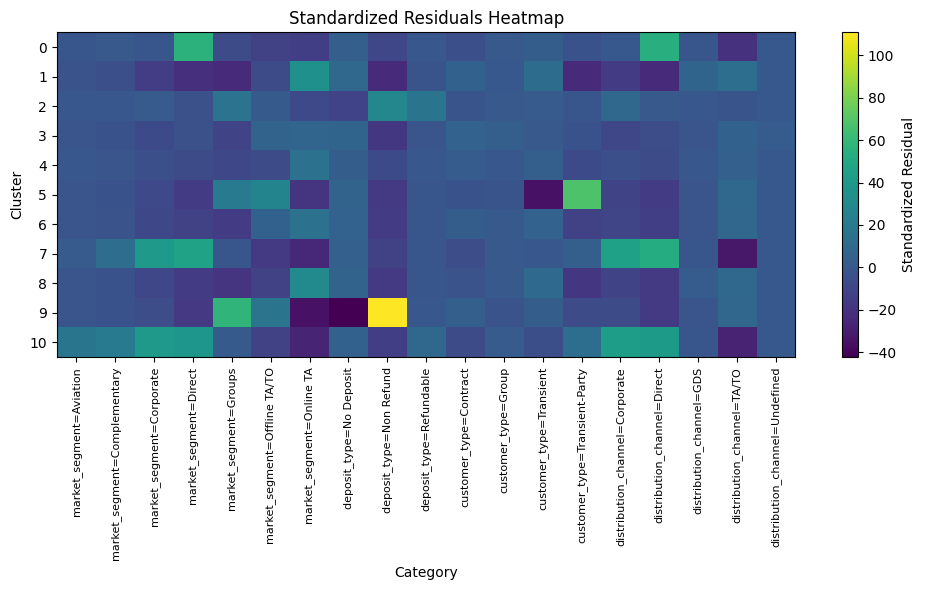

In [ ]:
res_df = pd.concat(residuals, axis=1)  # MultiIndex: (variable, category)

plt.figure(figsize=(10, 6))
plt.imshow(res_df.values, aspect='auto')
plt.colorbar(label='Standardized Residual')

plt.xticks(
    range(res_df.shape[1]),
    [f"{var}={cat}" for var, cat in res_df.columns],
    rotation=90, fontsize=8
)
plt.yticks(range(res_df.shape[0]), res_df.index.astype(str))
plt.title('Standardized Residuals Heatmap')
plt.xlabel('Category')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()
